<a href="https://colab.research.google.com/github/elvispreakerebi/fake-review-detection/blob/main/ElvisPreyeKerebi_fake_reviews_ml_dl_summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake Review Detection: Traditional ML vs Deep Learning

## Summative Project: Introduction to Machine Learning

**Problem Statement:** Binary classification of product reviews as **fake (CG – computer-generated)** or **real (OR – original)** from review text and metadata.

**Dataset:** fake_reviews_dataset.csv (category, rating, label, text_)

**Approach:**
- **Traditional ML:** Logistic Regression with TF-IDF (unigrams + bigrams), optional category and rating; stratified train/val/test; metrics: accuracy, precision, recall, F1, ROC-AUC, confusion matrix.
- **Deep Learning:** Embedding → Bidirectional LSTM → Dense with dropout; binary cross-entropy; early stopping and class weighting.

---

## 1. Import Libraries

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Traditional ML
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, log_loss
)
from scipy.sparse import hstack

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')
import gdown

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")

2026-02-14 17:15:19.919756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
Pandas version: 3.0.0


## 2. Data Loading and Preprocessing Functions

In [ ]:
def load_data(google_drive_url='https://drive.google.com/file/d/1pTiqJkiLScIeHVARqK5lTQ8WHXkQIZcM/view?usp=sharing', file_id=None, filename='fake_reviews_dataset.csv'):
    """
    Load fake reviews dataset: from Google Drive (if URL or file_id given) or from local file.

    Args:
        google_drive_url (str, optional): Full Google Drive share URL (e.g. https://drive.google.com/file/d/XXX/view?usp=sharing)
        file_id (str, optional): Google Drive file ID (extracted from URL if not provided)
        filename (str): Name to save the downloaded file, or path to local file

    Returns:
        pd.DataFrame: Loaded dataset
    """
    import os
    import re

    # If first arg looks like a local filename (e.g. load_data('fake_reviews_dataset.csv')), use it
    if google_drive_url is not None and 'drive.google.com' not in google_drive_url:
        filename = google_drive_url
        google_drive_url = None

    # Load from local file if no Drive URL/file_id
    if not google_drive_url and not file_id:
        if os.path.exists(filename):
            print(f"Loading from local file: {filename}")
            df = pd.read_csv(filename)
        else:
            raise ValueError(
                f"File '{filename}' not found. "
                "Upload fake_reviews_dataset.csv to Google Drive, set FAKE_REVIEWS_DRIVE_URL to the share link, "
                "and call load_data(google_drive_url=FAKE_REVIEWS_DRIVE_URL), or place the file in this directory."
            )
        df['text_'] = df['text_'].fillna('').astype(str)
        df = df.dropna(subset=['label'])
        print(f"Dataset shape: {df.shape}\nLabel counts:\n{df['label'].value_counts()}\nSample:\n{df[['label', 'rating', 'text_']].head()}")
        return df

    # Extract file ID from Google Drive URL if needed
    if google_drive_url:
        match = re.search(r'/d/([a-zA-Z0-9_-]+)', google_drive_url)
        if match:
            file_id = match.group(1)
        else:
            raise ValueError("Could not extract file ID from Google Drive URL. Use a share link like https://drive.google.com/file/d/XXX/view?usp=sharing")
    if not file_id:
        raise ValueError("Either google_drive_url or file_id must be provided")

    # Download from Google Drive if not already present
    if not os.path.exists(filename):
        print(f"Downloading from Google Drive...")
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, filename, quiet=False)
        print(f"Downloaded: {filename}")
    else:
        print(f"File already exists: {filename}")

    df = pd.read_csv(filename)
    df['text_'] = df['text_'].fillna('').astype(str)
    df = df.dropna(subset=['label'])
    print(f"\nDataset shape: {df.shape}\nLabel counts:\n{df['label'].value_counts()}\nSample:\n{df[['label', 'rating', 'text_']].head()}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    return df

In [ ]:
def preprocess_data_for_ml(df, text_col='text_', target_col='label', category_col='category', rating_col='rating',
                           max_features=20000, min_df=2, ngram_range=(1, 2), test_size=0.15, val_size=0.15, random_state=42):
    """
    Preprocess for traditional ML: TF-IDF on text (ngram_range), one-hot category, numeric rating.
    Stratified train/val/test split (1 - test_size - val_size, val_size, test_size).
    Returns: X_train, X_val, X_test, y_train, y_val, y_test, vectorizer, onehot_encoder
    """
    y = (df[target_col] == 'CG').astype(int).values  # CG=1, OR=0
    n = len(df)
    idx = np.arange(n)
    idx_train, idx_rest = train_test_split(idx, test_size=(val_size + test_size), stratify=y, random_state=random_state)
    y_rest = y[idx_rest]
    idx_val, idx_test = train_test_split(idx_rest, test_size=test_size / (val_size + test_size), stratify=y_rest, random_state=random_state)

    X_text_train = df[text_col].iloc[idx_train].values
    X_text_val = df[text_col].iloc[idx_val].values
    X_text_test = df[text_col].iloc[idx_test].values

    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features, min_df=min_df, sublinear_tf=True)
    X_train_tfidf = vectorizer.fit_transform(X_text_train)
    X_val_tfidf = vectorizer.transform(X_text_val)
    X_test_tfidf = vectorizer.transform(X_text_test)

    onehot = OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore')
    X_cat_train = onehot.fit_transform(df[[category_col]].iloc[idx_train])
    X_cat_val = onehot.transform(df[[category_col]].iloc[idx_val])
    X_cat_test = onehot.transform(df[[category_col]].iloc[idx_test])

    r_train = df[rating_col].iloc[idx_train].values.reshape(-1, 1)
    r_val = df[rating_col].iloc[idx_val].values.reshape(-1, 1)
    r_test = df[rating_col].iloc[idx_test].values.reshape(-1, 1)

    X_train_ml = hstack([X_train_tfidf, X_cat_train, r_train])
    X_val_ml = hstack([X_val_tfidf, X_cat_val, r_val])
    X_test_ml = hstack([X_test_tfidf, X_cat_test, r_test])

    y_train = y[idx_train]
    y_val = y[idx_val]
    y_test = y[idx_test]

    print(f"Train {X_train_ml.shape[0]}, Val {X_val_ml.shape[0]}, Test {X_test_ml.shape[0]}")
    print(f"Train class counts: {np.bincount(y_train)}; Val: {np.bincount(y_val)}; Test: {np.bincount(y_test)}")
    return X_train_ml, X_val_ml, X_test_ml, y_train, y_val, y_test, vectorizer, onehot

In [ ]:
def preprocess_data_for_dl(df, text_col='text_', target_col='label', max_len=200, vocab_size=20000,
                           test_size=0.15, val_size=0.15, random_state=42):
    """
    Preprocess for DL: tokenize text, pad to max_len, binary target. Same stratified split as ML.
    Returns: X_train, X_val, X_test (padded sequences), y_train, y_val, y_test (0/1), tokenizer, max_len
    """
    y = (df[target_col] == 'CG').astype(int).values
    n = len(df)
    idx = np.arange(n)
    idx_train, idx_rest = train_test_split(idx, test_size=(val_size + test_size), stratify=y, random_state=random_state)
    y_rest = y[idx_rest]
    idx_val, idx_test = train_test_split(idx_rest, test_size=test_size / (val_size + test_size), stratify=y_rest, random_state=random_state)

    texts_train = df[text_col].iloc[idx_train].astype(str).tolist()
    texts_val = df[text_col].iloc[idx_val].astype(str).tolist()
    texts_test = df[text_col].iloc[idx_test].astype(str).tolist()

    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts_train)
    X_train_seq = tokenizer.texts_to_sequences(texts_train)
    X_val_seq = tokenizer.texts_to_sequences(texts_val)
    X_test_seq = tokenizer.texts_to_sequences(texts_test)

    X_train_dl = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_val_dl = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_dl = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

    y_train = y[idx_train]
    y_val = y[idx_val]
    y_test = y[idx_test]

    print(f"DL shapes: train {X_train_dl.shape}, val {X_val_dl.shape}, test {X_test_dl.shape}")
    print(f"Vocab size (used): {min(vocab_size, len(tokenizer.word_index) + 1)}")
    return X_train_dl, X_val_dl, X_test_dl, y_train, y_val, y_test, tokenizer, max_len

## 3. Traditional ML: Logistic Regression
Training and evaluation run in **Section 7**; helper below for binary metrics.

In [ ]:
def evaluate_binary_clf(y_true, y_pred, y_proba=None, name=''):
    """Print and return metrics for binary classification (e.g. fake=1, real=0)."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba[:, 1]) if y_proba is not None else None
    cm = confusion_matrix(y_true, y_pred)
    if name:
        print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}" + (f"  ROC-AUC: {roc:.4f}" if roc is not None else ""))
    print("Confusion matrix:\n", cm)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc, 'confusion_matrix': cm}

In [ ]:
def evaluate_lr_experiment(lr_exp, experiment_name):
    """Print evaluation summary for an LR experiment (same style as 7-experiment flow)."""
    print(f"\n{'='*60}\nExperiment: {experiment_name}\n{'='*60}\n\nHyperparameters:")
    for k, v in lr_exp['hyperparameters'].items():
        print(f"  {k}: {v}")
    print(f"\nValidation: Accuracy={lr_exp['val_accuracy']:.4f}")
    print(f"Test: Accuracy={lr_exp['test_accuracy']:.4f}  Precision={lr_exp['precision']:.4f}  Recall={lr_exp['recall']:.4f}  F1={lr_exp['f1_score']:.4f}  ROC-AUC={lr_exp['roc_auc']:.4f}")
    print("\nConfusion matrix (test):\n", lr_exp['confusion_matrix'])
    return lr_exp

## 4. Deep Learning: BiLSTM for text classification

In [ ]:
def create_tf_dataset(X, y, batch_size=32, shuffle=True):
    """Create a tf.data.Dataset from (X, y). For binary classification, y can be (n,) or (n,1).
    Args: X (features), y (labels), batch_size, shuffle.
    Returns: tf.data.Dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
def build_bilstm_model(vocab_size, max_len, embedding_dim=128, lstm_units=64, dropout_rate=0.4, l2_reg=None):
    """Binary text classification: Embedding -> Bidirectional LSTM -> Dense -> Dropout -> Dense(1, sigmoid).
    Optional l2_reg (e.g. 1e-4) applies L2 weight decay to Embedding and Dense layers for better generalization."""
    reg = keras.regularizers.l2(l2_reg) if l2_reg is not None else None
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, embeddings_regularizer=reg),
        layers.Bidirectional(layers.LSTM(lstm_units)),
        layers.Dense(64, activation='relu', kernel_regularizer=reg),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid', kernel_regularizer=reg)
    ])
    return model

In [ ]:
def train_bilstm(model, train_dataset, val_dataset, class_weight=None, learning_rate=1e-3, epochs=20, patience=3, verbose=1, optimizer=None):
    """Train binary BiLSTM: binary_crossentropy, Adam (or optional optimizer), early stopping, ModelCheckpoint, ReduceLROnPlateau, optional class_weight."""
    opt = optimizer if optimizer is not None else keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint('best_bilstm.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ]
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=cb, class_weight=class_weight, verbose=verbose)
    val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
    return {'model': model, 'history': history, 'val_loss': val_loss, 'val_accuracy': val_acc}

## 5. Visualization Functions

In [ ]:
def plot_learning_curves(history, experiment_name):
    """
    Plot training and validation learning curves.

    Args:
        history: Keras training history
        experiment_name: Name of the experiment
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title(f'{experiment_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title(f'{experiment_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, target_encoder, experiment_name):
    """
    Plot confusion matrix.

    Args:
        cm: Confusion matrix
        target_encoder: LabelEncoder for target variable
        experiment_name: Name of the experiment
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc, experiment_name):
    """
    Plot ROC curve.

    Args:
        fpr: False positive rate array (from roc_curve)
        tpr: True positive rate array
        roc_auc: ROC AUC score
        experiment_name: Name of the experiment
    """
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {experiment_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_lr_learning_curves(model, X_train, y_train, experiment_name, cv=5, n_jobs=-1, train_sizes_frac=None):
    """
    Plot learning curves for a Logistic Regression (or other sklearn) model:
    train and validation accuracy vs training set size.

    Args:
        model: Fitted or unfitted sklearn classifier
        X_train: Training features
        y_train: Training labels
        experiment_name: Name of the experiment
        cv: Number of folds for learning_curve
        n_jobs: Number of jobs for parallel computation
        train_sizes_frac: Fractions of data for curve (e.g. np.linspace(0.25, 1.0, 4)). Use fewer for slow models (e.g. L1+saga).
    """
    if train_sizes_frac is None:
        train_sizes_frac = np.linspace(0.1, 1.0, 5)
    sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=n_jobs,
        train_sizes=train_sizes_frac, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    plt.figure(figsize=(8, 5))
    plt.fill_between(sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2)
    plt.plot(sizes_abs, train_mean, 'o-', label='Train Accuracy')
    plt.plot(sizes_abs, val_mean, 'o-', label='Val Accuracy')
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curves - {experiment_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 6. Load and Preprocess Data

In [ ]:
# Load fake reviews dataset: from local file if present, else use Google Drive URL below
# To download from Google Drive: upload the file, get share link, set it here and use load_data(google_drive_url=FAKE_REVIEWS_DRIVE_URL)
# FAKE_REVIEWS_DRIVE_URL = 'https://drive.google.com/file/d/YOUR_FILE_ID/view?usp=sharing'
df = load_data()

File already exists: fake_reviews_dataset.csv

Dataset shape: (40432, 4)
Label counts:
label
CG    20216
OR    20216
Name: count, dtype: int64
Sample:
  label  rating                                              text_
0    CG     5.0  Love this!  Well made, sturdy, and very comfor...
1    CG     5.0  love it, a great upgrade from the original.  I...
2    CG     5.0  This pillow saved my back. I love the look and...
3    CG     1.0  Missing information on how to use it, but it i...
4    CG     5.0  Very nice set. Good quality. We have had the s...

Missing values:
category    0
rating      0
label       0
text_       0
dtype: int64


In [ ]:
# Preprocess for Traditional ML (TF-IDF + category + rating; stratified train/val/test)
X_train_ml, X_val_ml, X_test_ml, y_train_ml, y_val_ml, y_test_ml, vectorizer_ml, onehot_ml = preprocess_data_for_ml(df)

Train 28302, Val 6065, Test 6065
Train class counts: [14151 14151]; Val: [3032 3033]; Test: [3033 3032]


In [ ]:
# Preprocess for Deep Learning (tokenize, pad; same stratified split)
X_train_dl, X_val_dl, X_test_dl, y_train_dl, y_val_dl, y_test_dl, tokenizer_dl, max_len = preprocess_data_for_dl(df)
vocab_size = min(20000, len(tokenizer_dl.word_index) + 2)  # +2 for padding and OOV

DL shapes: train (28302, 200), val (6065, 200), test (6065, 200)
Vocab size (used): 20000


## 7. Traditional ML: Logistic Regression (8 experiments)

**Optimizer and iterations (epochs):** Logistic Regression is trained with **iterative gradient-based optimization**. We use the **SAGA** solver (stochastic average gradient descent), which is suitable for large datasets. **`max_iter`** is the maximum number of iterations (analogous to epochs in DL); training stops when convergence is reached or this limit is hit.

### Experiment 1: Baseline

In [ ]:
# LR Experiment 1: Baseline (SAGA optimizer, C=1.0, class_weight='balanced', max_iter=epochs)
# SAGA = stochastic average gradient descent; max_iter = max optimization iterations (like DL epochs)
lr_exp1_model = LogisticRegression(solver='saga', class_weight='balanced', C=1.0, max_iter=1000, random_state=42)
lr_exp1_model.fit(X_train_ml, y_train_ml)
y_val_pred_1 = lr_exp1_model.predict(X_val_ml)
y_test_pred_1 = lr_exp1_model.predict(X_test_ml)
y_val_proba_1 = lr_exp1_model.predict_proba(X_val_ml)
y_test_proba_1 = lr_exp1_model.predict_proba(X_test_ml)
val_m1 = evaluate_binary_clf(y_val_ml, y_val_pred_1, y_val_proba_1, "Val")
test_m1 = evaluate_binary_clf(y_test_ml, y_test_pred_1, y_test_proba_1, "Test")
lr_exp1 = {
    'model': lr_exp1_model,
    'y_val_pred': y_val_pred_1, 'y_test_pred': y_test_pred_1,
    'y_test_proba': y_test_proba_1,
    'val_accuracy': val_m1['accuracy'], 'test_accuracy': test_m1['accuracy'],
    'precision': test_m1['precision'], 'recall': test_m1['recall'],
    'f1_score': test_m1['f1'], 'roc_auc': test_m1['roc_auc'],
    'confusion_matrix': test_m1['confusion_matrix'],
    'hyperparameters': {'solver': 'saga', 'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000}
}
lr_exp1 = evaluate_lr_experiment(lr_exp1, 'LR Experiment 1: Baseline')

--- Val ---
Accuracy: 0.9344  Precision: 0.9468  Recall: 0.9205  F1: 0.9335  ROC-AUC: 0.9840
Confusion matrix:
 [[2875  157]
 [ 241 2792]]
--- Test ---
Accuracy: 0.9365  Precision: 0.9470  Recall: 0.9248  F1: 0.9358  ROC-AUC: 0.9839
Confusion matrix:
 [[2876  157]
 [ 228 2804]]

Experiment: LR Experiment 1: Baseline

Hyperparameters:
  solver: saga
  C: 1.0
  class_weight: balanced
  max_iter: 1000

Validation: Accuracy=0.9344
Test: Accuracy=0.9365  Precision=0.9470  Recall=0.9248  F1=0.9358  ROC-AUC=0.9839

Confusion matrix (test):
 [[2876  157]
 [ 228 2804]]


### ROC curve and confusion matrix (Logistic Regression)

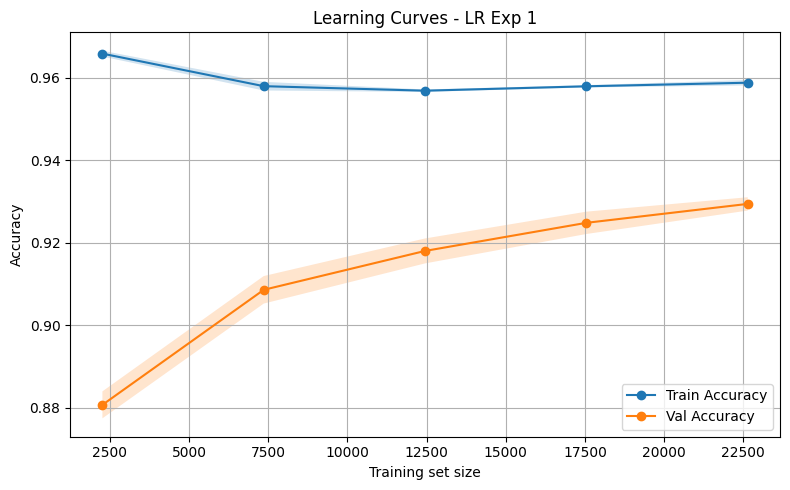

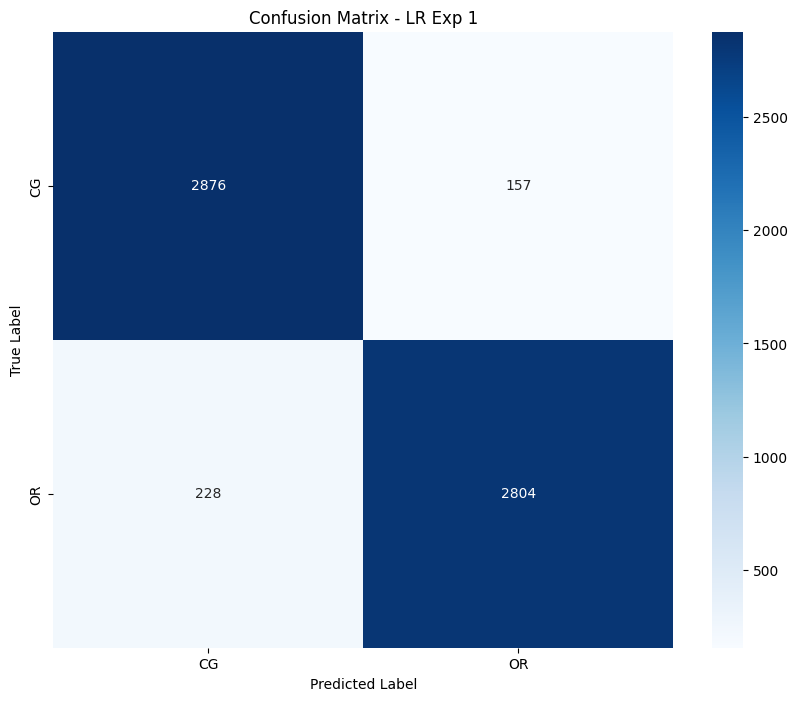

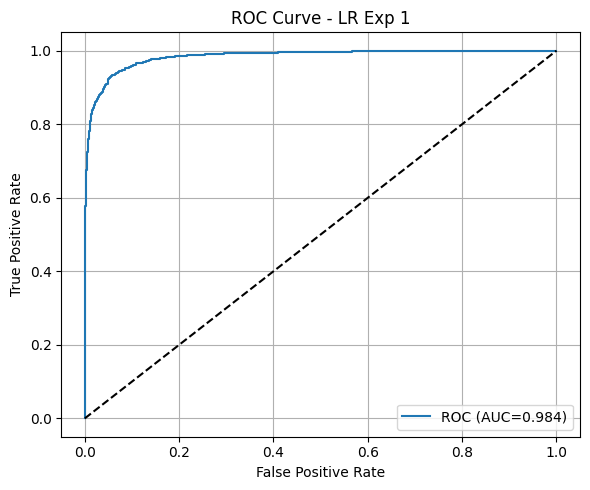

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 1 (using visualization functions)
le_ml = LabelEncoder()
le_ml.fit(['OR', 'CG'])

plot_lr_learning_curves(lr_exp1['model'], X_train_ml, y_train_ml, 'LR Exp 1')
plot_confusion_matrix(lr_exp1['confusion_matrix'], le_ml, 'LR Exp 1')

fpr, tpr, _ = roc_curve(y_test_ml, lr_exp1['y_test_proba'][:, 1])
plot_roc_curve(fpr, tpr, lr_exp1['roc_auc'], 'LR Exp 1')

### Experiment 2: Stronger regularization (C=0.5)

Addresses overfitting seen in Exp 1 learning curves (train–val gap) by increasing regularization. Same solver, class_weight, and max_iter.

In [ ]:
# LR Experiment 2: Stronger regularization (C=0.5)
lr_exp2_model = LogisticRegression(solver='saga', class_weight='balanced', C=0.5, max_iter=1000, random_state=42)
lr_exp2_model.fit(X_train_ml, y_train_ml)
y_val_pred_2 = lr_exp2_model.predict(X_val_ml)
y_test_pred_2 = lr_exp2_model.predict(X_test_ml)
y_val_proba_2 = lr_exp2_model.predict_proba(X_val_ml)
y_test_proba_2 = lr_exp2_model.predict_proba(X_test_ml)
val_m2 = evaluate_binary_clf(y_val_ml, y_val_pred_2, y_val_proba_2, "Val")
test_m2 = evaluate_binary_clf(y_test_ml, y_test_pred_2, y_test_proba_2, "Test")
lr_exp2 = {
    'model': lr_exp2_model,
    'y_val_pred': y_val_pred_2, 'y_test_pred': y_test_pred_2,
    'y_test_proba': y_test_proba_2,
    'val_accuracy': val_m2['accuracy'], 'test_accuracy': test_m2['accuracy'],
    'precision': test_m2['precision'], 'recall': test_m2['recall'],
    'f1_score': test_m2['f1'], 'roc_auc': test_m2['roc_auc'],
    'confusion_matrix': test_m2['confusion_matrix'],
    'hyperparameters': {'solver': 'saga', 'C': 0.5, 'class_weight': 'balanced', 'max_iter': 1000}
}
lr_exp2 = evaluate_lr_experiment(lr_exp2, 'LR Experiment 2: Stronger regularization (C=0.5)')

--- Val ---
Accuracy: 0.9296  Precision: 0.9444  Recall: 0.9130  F1: 0.9284  ROC-AUC: 0.9807
Confusion matrix:
 [[2869  163]
 [ 264 2769]]
--- Test ---
Accuracy: 0.9286  Precision: 0.9419  Recall: 0.9136  F1: 0.9275  ROC-AUC: 0.9803
Confusion matrix:
 [[2862  171]
 [ 262 2770]]

Experiment: LR Experiment 2: Stronger regularization (C=0.5)

Hyperparameters:
  solver: saga
  C: 0.5
  class_weight: balanced
  max_iter: 1000

Validation: Accuracy=0.9296
Test: Accuracy=0.9286  Precision=0.9419  Recall=0.9136  F1=0.9275  ROC-AUC=0.9803

Confusion matrix (test):
 [[2862  171]
 [ 262 2770]]


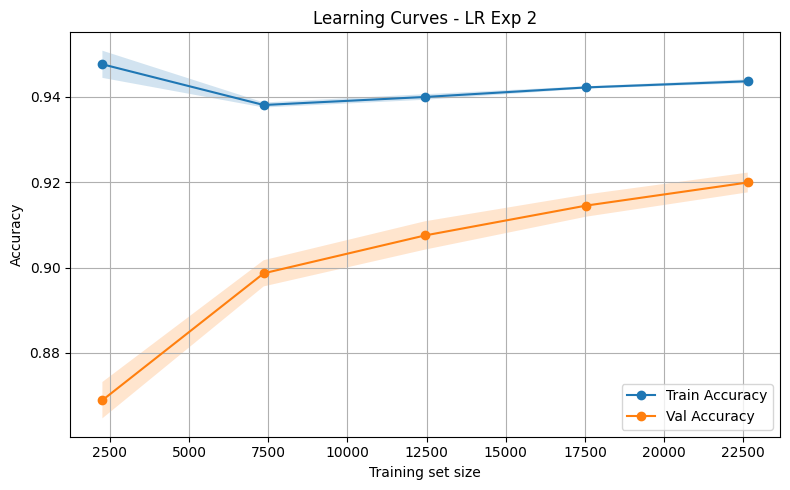

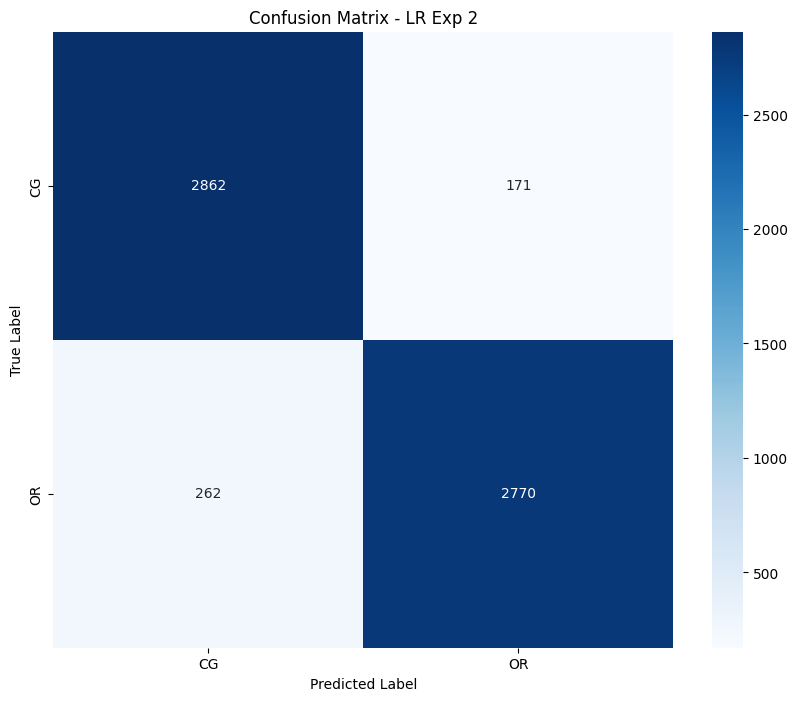

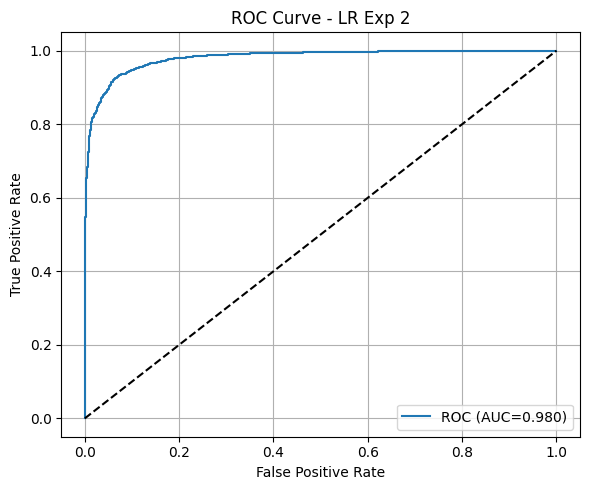

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 2 (using visualization functions)
plot_lr_learning_curves(lr_exp2['model'], X_train_ml, y_train_ml, 'LR Exp 2')
plot_confusion_matrix(lr_exp2['confusion_matrix'], le_ml, 'LR Exp 2')
fpr2, tpr2, _ = roc_curve(y_test_ml, lr_exp2['y_test_proba'][:, 1])
plot_roc_curve(fpr2, tpr2, lr_exp2['roc_auc'], 'LR Exp 2')

### Experiment 3: Middle-ground regularization (C=0.8) + liblinear solver

Exp2 (C=0.5) underfit slightly; Exp1 (C=1.0) remains best. Here we try **C=0.8** (between the two) and **solver='liblinear'** for a different optimization path that can generalize well.

In [ ]:
# LR Experiment 3: C=0.8, solver=liblinear
lr_exp3_model = LogisticRegression(solver='liblinear', class_weight='balanced', C=0.8, max_iter=1000, random_state=42)
lr_exp3_model.fit(X_train_ml, y_train_ml)
y_val_pred_3 = lr_exp3_model.predict(X_val_ml)
y_test_pred_3 = lr_exp3_model.predict(X_test_ml)
y_val_proba_3 = lr_exp3_model.predict_proba(X_val_ml)
y_test_proba_3 = lr_exp3_model.predict_proba(X_test_ml)
val_m3 = evaluate_binary_clf(y_val_ml, y_val_pred_3, y_val_proba_3, "Val")
test_m3 = evaluate_binary_clf(y_test_ml, y_test_pred_3, y_test_proba_3, "Test")
lr_exp3 = {
    'model': lr_exp3_model,
    'y_val_pred': y_val_pred_3, 'y_test_pred': y_test_pred_3,
    'y_test_proba': y_test_proba_3,
    'val_accuracy': val_m3['accuracy'], 'test_accuracy': test_m3['accuracy'],
    'precision': test_m3['precision'], 'recall': test_m3['recall'],
    'f1_score': test_m3['f1'], 'roc_auc': test_m3['roc_auc'],
    'confusion_matrix': test_m3['confusion_matrix'],
    'hyperparameters': {'solver': 'liblinear', 'C': 0.8, 'class_weight': 'balanced', 'max_iter': 1000}
}
lr_exp3 = evaluate_lr_experiment(lr_exp3, 'LR Experiment 3: C=0.8 + liblinear')

--- Val ---
Accuracy: 0.9329  Precision: 0.9457  Recall: 0.9186  F1: 0.9319  ROC-AUC: 0.9831
Confusion matrix:
 [[2872  160]
 [ 247 2786]]
--- Test ---
Accuracy: 0.9334  Precision: 0.9448  Recall: 0.9205  F1: 0.9325  ROC-AUC: 0.9829
Confusion matrix:
 [[2870  163]
 [ 241 2791]]

Experiment: LR Experiment 3: C=0.8 + liblinear

Hyperparameters:
  solver: liblinear
  C: 0.8
  class_weight: balanced
  max_iter: 1000

Validation: Accuracy=0.9329
Test: Accuracy=0.9334  Precision=0.9448  Recall=0.9205  F1=0.9325  ROC-AUC=0.9829

Confusion matrix (test):
 [[2870  163]
 [ 241 2791]]


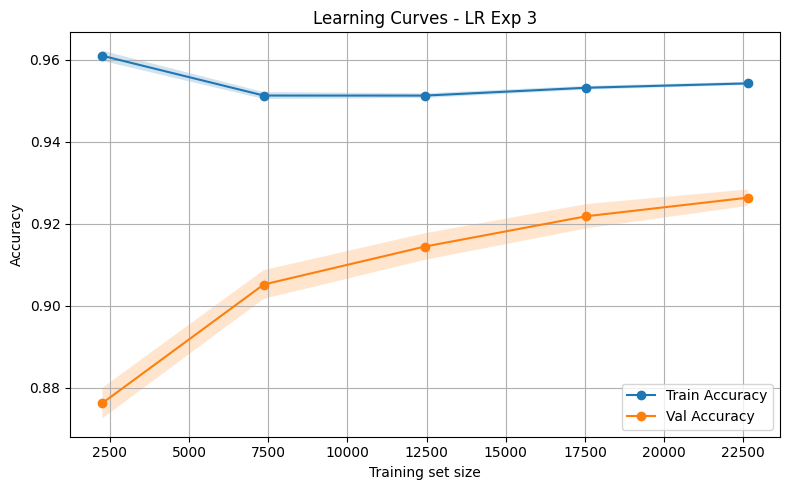

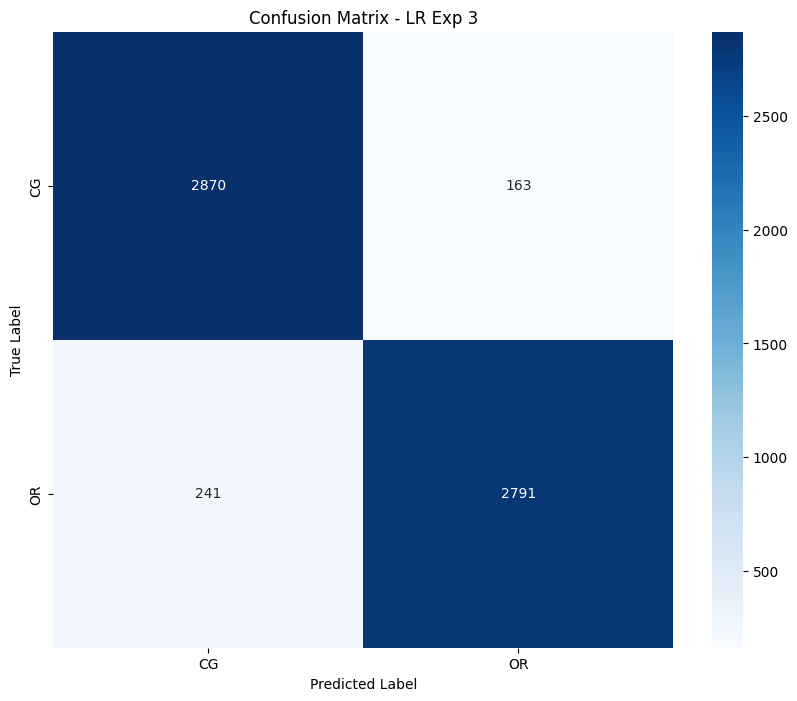

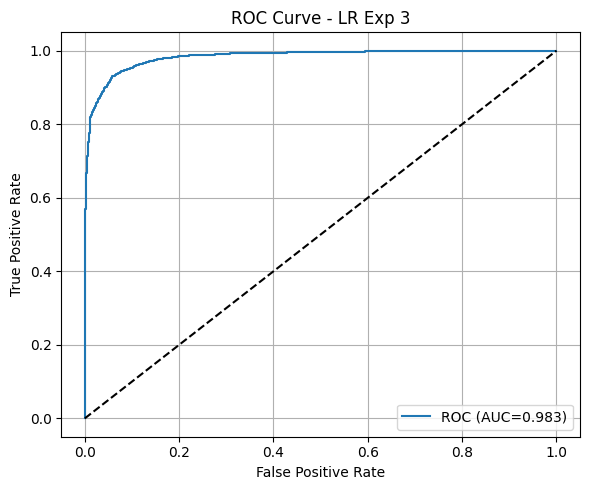

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 3
plot_lr_learning_curves(lr_exp3['model'], X_train_ml, y_train_ml, 'LR Exp 3')
plot_confusion_matrix(lr_exp3['confusion_matrix'], le_ml, 'LR Exp 3')
fpr3, tpr3, _ = roc_curve(y_test_ml, lr_exp3['y_test_proba'][:, 1])
plot_roc_curve(fpr3, tpr3, lr_exp3['roc_auc'], 'LR Exp 3')

### Experiment 4: saga + C=0.9 (mild regularization vs best Exp 1)

Exp1 (saga, C=1.0) is still best; Exp3 (liblinear, C=0.8) closed the train–val gap but test is slightly lower. Here we use **solver='saga'** again with **C=0.9** to add a small amount of regularization and see if we keep or beat Exp1 test performance while improving generalization.

In [ ]:
# LR Experiment 4: saga + C=0.9
lr_exp4_model = LogisticRegression(solver='saga', class_weight='balanced', C=0.9, max_iter=1000, random_state=42)
lr_exp4_model.fit(X_train_ml, y_train_ml)
y_val_pred_4 = lr_exp4_model.predict(X_val_ml)
y_test_pred_4 = lr_exp4_model.predict(X_test_ml)
y_val_proba_4 = lr_exp4_model.predict_proba(X_val_ml)
y_test_proba_4 = lr_exp4_model.predict_proba(X_test_ml)
val_m4 = evaluate_binary_clf(y_val_ml, y_val_pred_4, y_val_proba_4, "Val")
test_m4 = evaluate_binary_clf(y_test_ml, y_test_pred_4, y_test_proba_4, "Test")
lr_exp4 = {
    'model': lr_exp4_model,
    'y_val_pred': y_val_pred_4, 'y_test_pred': y_test_pred_4,
    'y_test_proba': y_test_proba_4,
    'val_accuracy': val_m4['accuracy'], 'test_accuracy': test_m4['accuracy'],
    'precision': test_m4['precision'], 'recall': test_m4['recall'],
    'f1_score': test_m4['f1'], 'roc_auc': test_m4['roc_auc'],
    'confusion_matrix': test_m4['confusion_matrix'],
    'hyperparameters': {'solver': 'saga', 'C': 0.9, 'class_weight': 'balanced', 'max_iter': 1000}
}
lr_exp4 = evaluate_lr_experiment(lr_exp4, 'LR Experiment 4: saga + C=0.9')

--- Val ---
Accuracy: 0.9340  Precision: 0.9470  Recall: 0.9196  F1: 0.9331  ROC-AUC: 0.9836
Confusion matrix:
 [[2876  156]
 [ 244 2789]]
--- Test ---
Accuracy: 0.9350  Precision: 0.9453  Recall: 0.9235  F1: 0.9343  ROC-AUC: 0.9834
Confusion matrix:
 [[2871  162]
 [ 232 2800]]

Experiment: LR Experiment 4: saga + C=0.9

Hyperparameters:
  solver: saga
  C: 0.9
  class_weight: balanced
  max_iter: 1000

Validation: Accuracy=0.9340
Test: Accuracy=0.9350  Precision=0.9453  Recall=0.9235  F1=0.9343  ROC-AUC=0.9834

Confusion matrix (test):
 [[2871  162]
 [ 232 2800]]


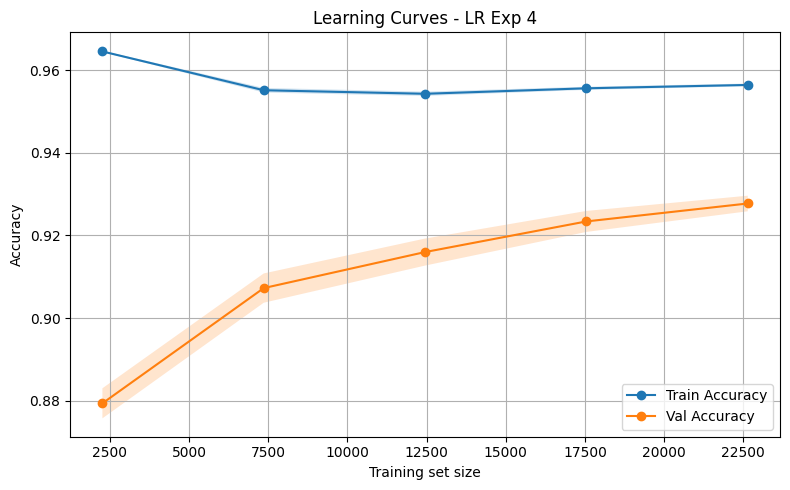

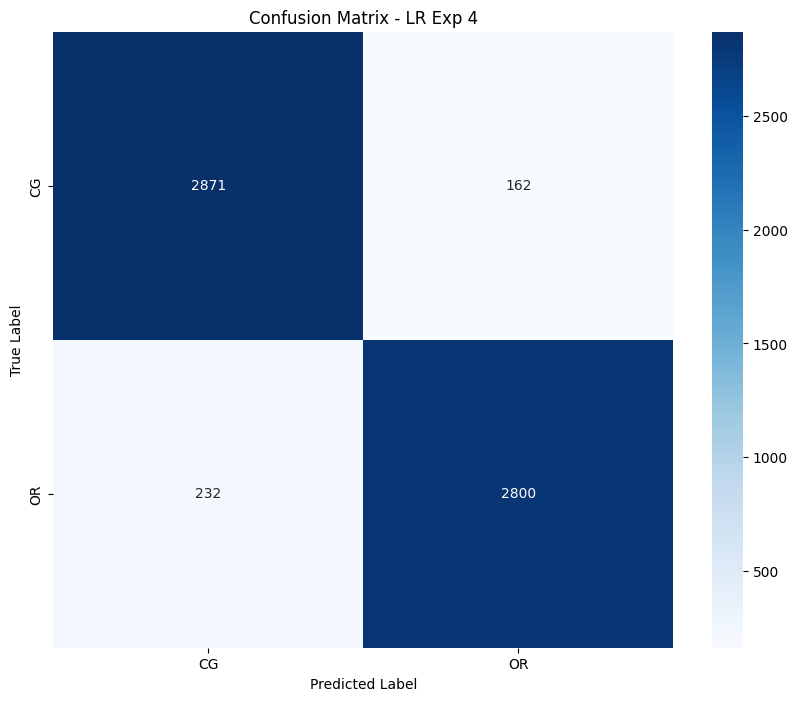

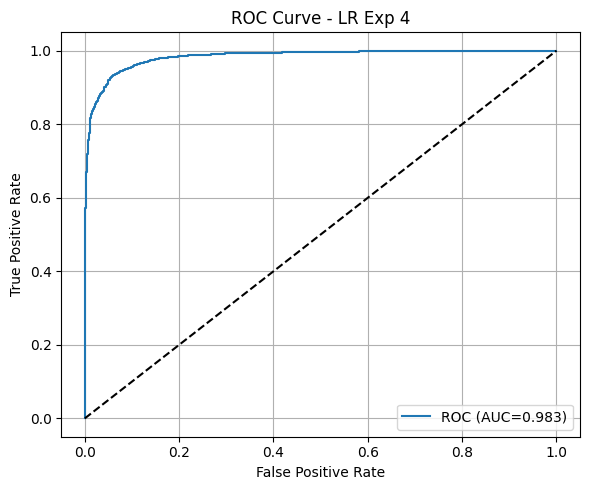

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 4
plot_lr_learning_curves(lr_exp4['model'], X_train_ml, y_train_ml, 'LR Exp 4')
plot_confusion_matrix(lr_exp4['confusion_matrix'], le_ml, 'LR Exp 4')
fpr4, tpr4, _ = roc_curve(y_test_ml, lr_exp4['y_test_proba'][:, 1])
plot_roc_curve(fpr4, tpr4, lr_exp4['roc_auc'], 'LR Exp 4')

### Experiment 5: L1 penalty (saga + C=1.0)

Exp1 and Exp4 are best so far; learning curves still show a train–val gap. Here we try **penalty='l1'** with **solver='saga'** and **C=1.0**. L1 encourages sparse coefficients (feature selection), which can reduce overfitting in a different way than L2 and sometimes improves generalization.

In [ ]:
# LR Experiment 5: L1 penalty, saga, C=1.0
lr_exp5_model = LogisticRegression(solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=1000, random_state=42)
lr_exp5_model.fit(X_train_ml, y_train_ml)
y_val_pred_5 = lr_exp5_model.predict(X_val_ml)
y_test_pred_5 = lr_exp5_model.predict(X_test_ml)
y_val_proba_5 = lr_exp5_model.predict_proba(X_val_ml)
y_test_proba_5 = lr_exp5_model.predict_proba(X_test_ml)
val_m5 = evaluate_binary_clf(y_val_ml, y_val_pred_5, y_val_proba_5, "Val")
test_m5 = evaluate_binary_clf(y_test_ml, y_test_pred_5, y_test_proba_5, "Test")
lr_exp5 = {
    'model': lr_exp5_model,
    'y_val_pred': y_val_pred_5, 'y_test_pred': y_test_pred_5,
    'y_test_proba': y_test_proba_5,
    'val_accuracy': val_m5['accuracy'], 'test_accuracy': test_m5['accuracy'],
    'precision': test_m5['precision'], 'recall': test_m5['recall'],
    'f1_score': test_m5['f1'], 'roc_auc': test_m5['roc_auc'],
    'confusion_matrix': test_m5['confusion_matrix'],
    'hyperparameters': {'solver': 'saga', 'penalty': 'l1', 'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000}
}
lr_exp5 = evaluate_lr_experiment(lr_exp5, 'LR Experiment 5: L1 penalty (saga, C=1.0)')

--- Val ---
Accuracy: 0.9265  Precision: 0.9363  Recall: 0.9153  F1: 0.9256  ROC-AUC: 0.9784
Confusion matrix:
 [[2843  189]
 [ 257 2776]]
--- Test ---
Accuracy: 0.9199  Precision: 0.9301  Recall: 0.9080  F1: 0.9189  ROC-AUC: 0.9759
Confusion matrix:
 [[2826  207]
 [ 279 2753]]

Experiment: LR Experiment 5: L1 penalty (saga, C=1.0)

Hyperparameters:
  solver: saga
  penalty: l1
  C: 1.0
  class_weight: balanced
  max_iter: 1000

Validation: Accuracy=0.9265
Test: Accuracy=0.9199  Precision=0.9301  Recall=0.9080  F1=0.9189  ROC-AUC=0.9759

Confusion matrix (test):
 [[2826  207]
 [ 279 2753]]


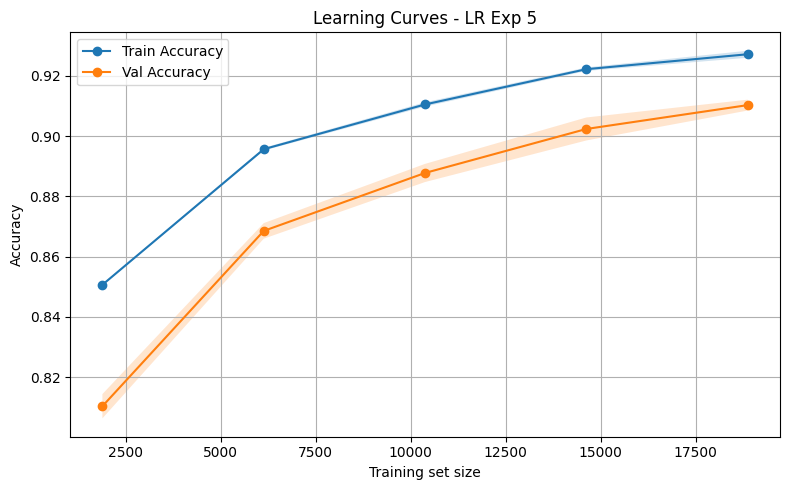

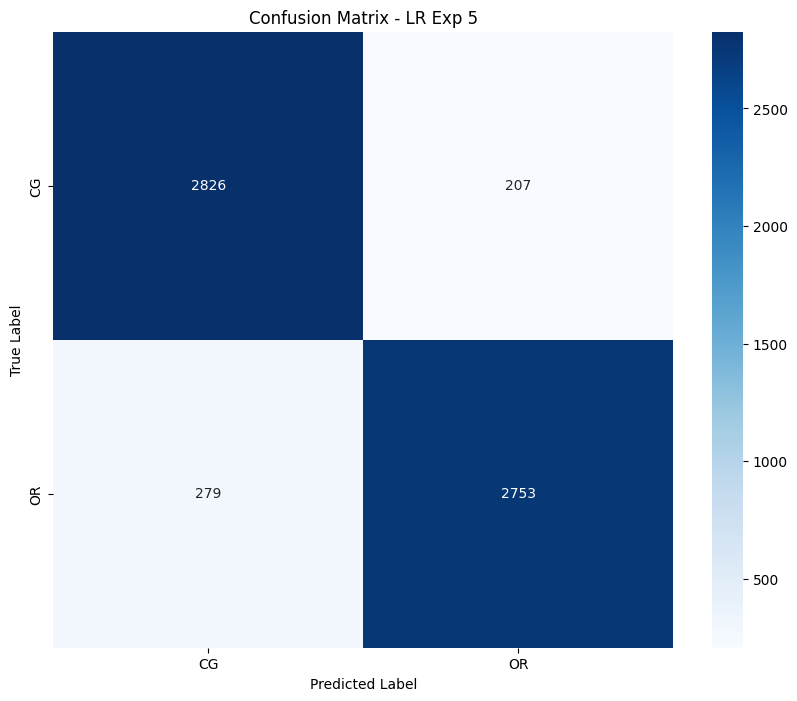

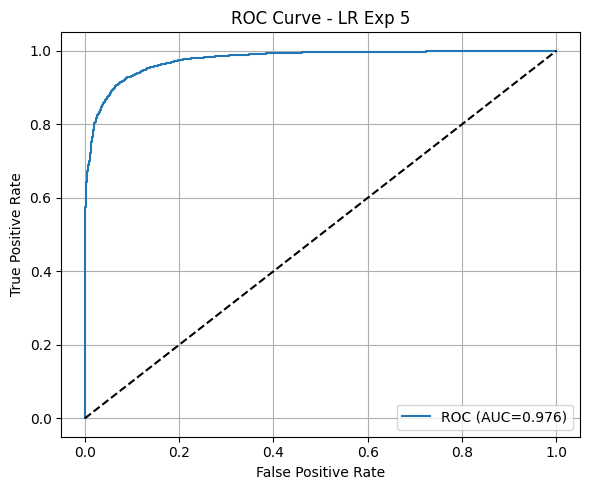

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 5
# L1+saga is slow: fewer cv folds (3) to speed up. Re-run the cell that defines plot_lr_learning_curves
# to enable train_sizes_frac=np.linspace(0.25, 1.0, 4) for even faster curves.
plot_lr_learning_curves(lr_exp5['model'], X_train_ml, y_train_ml, 'LR Exp 5', cv=3)
plot_confusion_matrix(lr_exp5['confusion_matrix'], le_ml, 'LR Exp 5')
fpr5, tpr5, _ = roc_curve(y_test_ml, lr_exp5['y_test_proba'][:, 1])
plot_roc_curve(fpr5, tpr5, lr_exp5['roc_auc'], 'LR Exp 5')

### Experiment 6: LBFGS solver (L2, C=1.0)

Exp5 (L1 + saga) underperformed vs L2. Best so far remain exp1 (saga, C=1.0) and exp4 (saga, C=0.9). Here we try **solver='lbfgs'** with **C=1.0** and default L2. LBFGS is a different optimizer that can behave better on some problems and may match or improve on exp1.

In [ ]:
# LR Experiment 6: lbfgs + C=1.0 (L2)
lr_exp6_model = LogisticRegression(solver='lbfgs', class_weight='balanced', C=1.0, max_iter=1000, random_state=42)
lr_exp6_model.fit(X_train_ml, y_train_ml)
y_val_pred_6 = lr_exp6_model.predict(X_val_ml)
y_test_pred_6 = lr_exp6_model.predict(X_test_ml)
y_val_proba_6 = lr_exp6_model.predict_proba(X_val_ml)
y_test_proba_6 = lr_exp6_model.predict_proba(X_test_ml)
val_m6 = evaluate_binary_clf(y_val_ml, y_val_pred_6, y_val_proba_6, "Val")
test_m6 = evaluate_binary_clf(y_test_ml, y_test_pred_6, y_test_proba_6, "Test")
lr_exp6 = {
    'model': lr_exp6_model,
    'y_val_pred': y_val_pred_6, 'y_test_pred': y_test_pred_6,
    'y_test_proba': y_test_proba_6,
    'val_accuracy': val_m6['accuracy'], 'test_accuracy': test_m6['accuracy'],
    'precision': test_m6['precision'], 'recall': test_m6['recall'],
    'f1_score': test_m6['f1'], 'roc_auc': test_m6['roc_auc'],
    'confusion_matrix': test_m6['confusion_matrix'],
    'hyperparameters': {'solver': 'lbfgs', 'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000}
}
lr_exp6 = evaluate_lr_experiment(lr_exp6, 'LR Experiment 6: lbfgs + C=1.0')

--- Val ---
Accuracy: 0.9352  Precision: 0.9484  Recall: 0.9205  F1: 0.9342  ROC-AUC: 0.9839
Confusion matrix:
 [[2880  152]
 [ 241 2792]]
--- Test ---
Accuracy: 0.9369  Precision: 0.9470  Recall: 0.9255  F1: 0.9361  ROC-AUC: 0.9838
Confusion matrix:
 [[2876  157]
 [ 226 2806]]

Experiment: LR Experiment 6: lbfgs + C=1.0

Hyperparameters:
  solver: lbfgs
  C: 1.0
  class_weight: balanced
  max_iter: 1000

Validation: Accuracy=0.9352
Test: Accuracy=0.9369  Precision=0.9470  Recall=0.9255  F1=0.9361  ROC-AUC=0.9838

Confusion matrix (test):
 [[2876  157]
 [ 226 2806]]


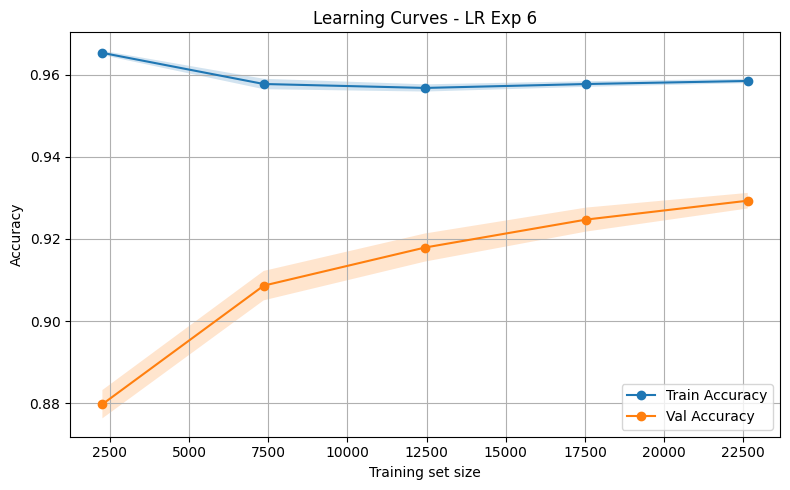

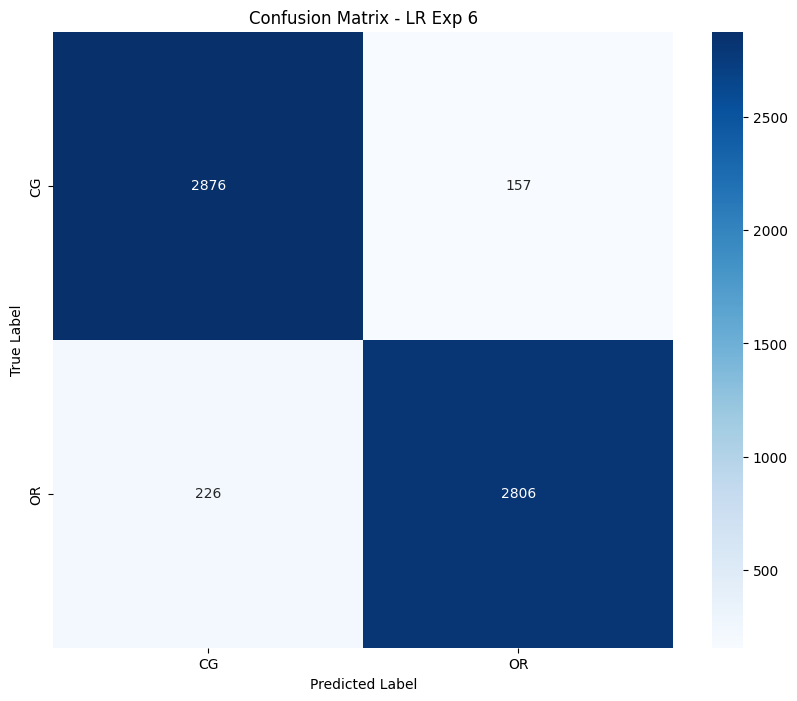

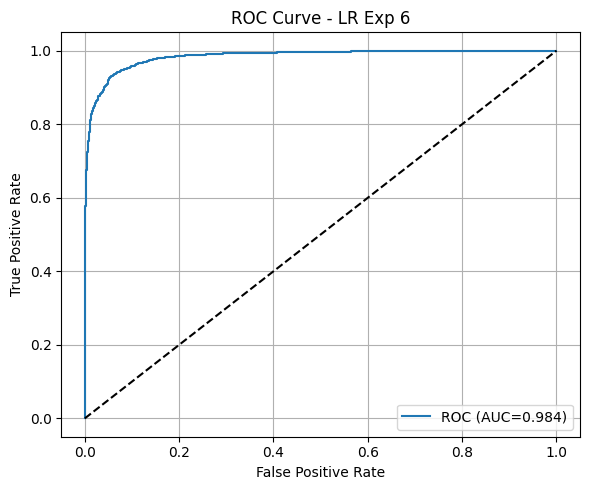

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 6
plot_lr_learning_curves(lr_exp6['model'], X_train_ml, y_train_ml, 'LR Exp 6')
plot_confusion_matrix(lr_exp6['confusion_matrix'], le_ml, 'LR Exp 6')
fpr6, tpr6, _ = roc_curve(y_test_ml, lr_exp6['y_test_proba'][:, 1])
plot_roc_curve(fpr6, tpr6, lr_exp6['roc_auc'], 'LR Exp 6')

### Experiment 7: LBFGS + mild regularization (C=0.95) to reduce overfitting

Exp6 (lbfgs, C=1.0) is best so far on test (0.9369) but learning curves still show a train–val gap. For the final experiment we use **solver='lbfgs'** with **C=0.95** — slightly stronger regularization than exp6 to narrow the gap and improve generalization while aiming to keep or match test performance.

In [ ]:
# LR Experiment 7: lbfgs + C=0.95 (mild regularization vs exp6)
lr_exp7_model = LogisticRegression(solver='lbfgs', class_weight='balanced', C=0.95, max_iter=1000, random_state=42)
lr_exp7_model.fit(X_train_ml, y_train_ml)
y_val_pred_7 = lr_exp7_model.predict(X_val_ml)
y_test_pred_7 = lr_exp7_model.predict(X_test_ml)
y_val_proba_7 = lr_exp7_model.predict_proba(X_val_ml)
y_test_proba_7 = lr_exp7_model.predict_proba(X_test_ml)
val_m7 = evaluate_binary_clf(y_val_ml, y_val_pred_7, y_val_proba_7, "Val")
test_m7 = evaluate_binary_clf(y_test_ml, y_test_pred_7, y_test_proba_7, "Test")
lr_exp7 = {
    'model': lr_exp7_model,
    'y_val_pred': y_val_pred_7, 'y_test_pred': y_test_pred_7,
    'y_test_proba': y_test_proba_7,
    'val_accuracy': val_m7['accuracy'], 'test_accuracy': test_m7['accuracy'],
    'precision': test_m7['precision'], 'recall': test_m7['recall'],
    'f1_score': test_m7['f1'], 'roc_auc': test_m7['roc_auc'],
    'confusion_matrix': test_m7['confusion_matrix'],
    'hyperparameters': {'solver': 'lbfgs', 'C': 0.95, 'class_weight': 'balanced', 'max_iter': 1000}
}
lr_exp7 = evaluate_lr_experiment(lr_exp7, 'LR Experiment 7: lbfgs + C=0.95 (reduce overfitting)')

--- Val ---
Accuracy: 0.9342  Precision: 0.9467  Recall: 0.9202  F1: 0.9333  ROC-AUC: 0.9841
Confusion matrix:
 [[2875  157]
 [ 242 2791]]
--- Test ---
Accuracy: 0.9369  Precision: 0.9476  Recall: 0.9248  F1: 0.9361  ROC-AUC: 0.9839
Confusion matrix:
 [[2878  155]
 [ 228 2804]]

Experiment: LR Experiment 7: lbfgs + C=0.95 (reduce overfitting)

Hyperparameters:
  solver: lbfgs
  C: 0.95
  class_weight: balanced
  max_iter: 1000

Validation: Accuracy=0.9342
Test: Accuracy=0.9369  Precision=0.9476  Recall=0.9248  F1=0.9361  ROC-AUC=0.9839

Confusion matrix (test):
 [[2878  155]
 [ 228 2804]]


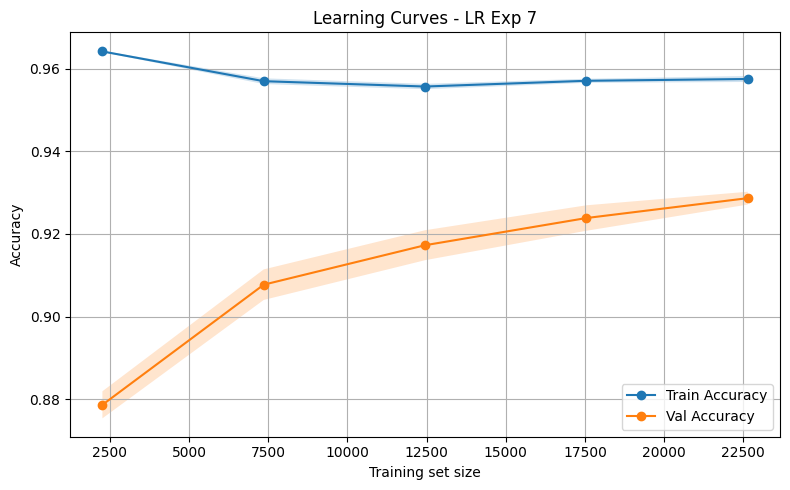

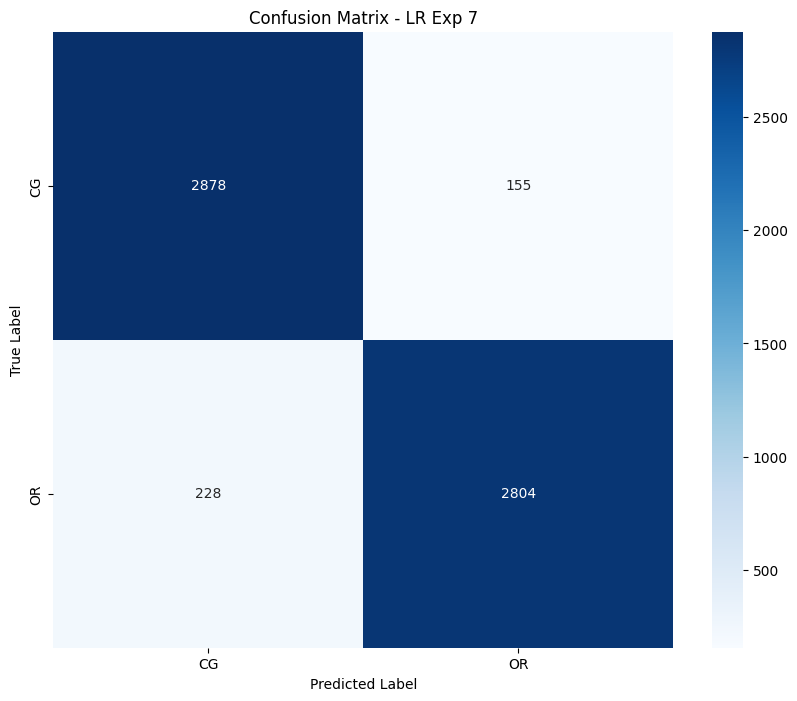

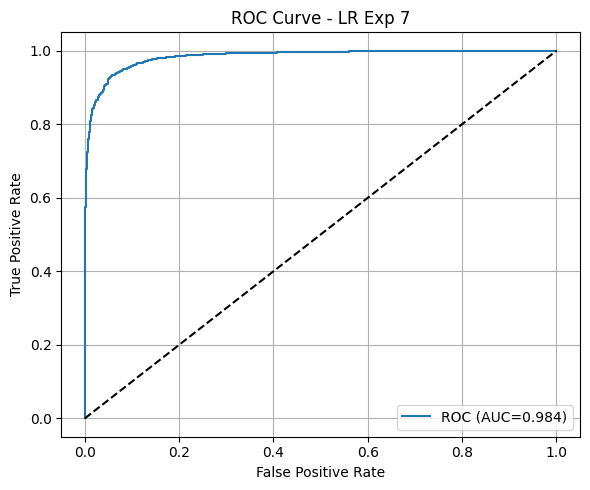

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 7
plot_lr_learning_curves(lr_exp7['model'], X_train_ml, y_train_ml, 'LR Exp 7')
plot_confusion_matrix(lr_exp7['confusion_matrix'], le_ml, 'LR Exp 7')
fpr7, tpr7, _ = roc_curve(y_test_ml, lr_exp7['y_test_proba'][:, 1])
plot_roc_curve(fpr7, tpr7, lr_exp7['roc_auc'], 'LR Exp 7')

### Experiment 8: Trigram TF-IDF + lbfgs C=0.95

Same LR config as best (lbfgs, C=0.95) but with **ngram_range=(1, 3)** so TF-IDF includes unigrams, bigrams, and trigrams. Richer text features may improve accuracy or ROC-AUC; same stratified split as other experiments.

In [ ]:
# LR Experiment 8: Trigram TF-IDF + lbfgs C=0.95 (same split, different features)
X_train_ml_8, X_val_ml_8, X_test_ml_8, y_train_ml_8, y_val_ml_8, y_test_ml_8, vectorizer_ml_8, onehot_ml_8 = preprocess_data_for_ml(df, ngram_range=(1, 3))

lr_exp8_model = LogisticRegression(solver='lbfgs', class_weight='balanced', C=0.95, max_iter=1000, random_state=42)
lr_exp8_model.fit(X_train_ml_8, y_train_ml_8)
y_val_pred_8 = lr_exp8_model.predict(X_val_ml_8)
y_test_pred_8 = lr_exp8_model.predict(X_test_ml_8)
y_val_proba_8 = lr_exp8_model.predict_proba(X_val_ml_8)
y_test_proba_8 = lr_exp8_model.predict_proba(X_test_ml_8)
val_m8 = evaluate_binary_clf(y_val_ml_8, y_val_pred_8, y_val_proba_8, "Val")
test_m8 = evaluate_binary_clf(y_test_ml_8, y_test_pred_8, y_test_proba_8, "Test")
lr_exp8 = {
    'model': lr_exp8_model,
    'y_val_pred': y_val_pred_8, 'y_test_pred': y_test_pred_8,
    'y_test_proba': y_test_proba_8,
    'val_accuracy': val_m8['accuracy'], 'test_accuracy': test_m8['accuracy'],
    'precision': test_m8['precision'], 'recall': test_m8['recall'],
    'f1_score': test_m8['f1'], 'roc_auc': test_m8['roc_auc'],
    'confusion_matrix': test_m8['confusion_matrix'],
    'hyperparameters': {'solver': 'lbfgs', 'C': 0.95, 'class_weight': 'balanced', 'max_iter': 1000, 'ngram_range': (1, 3)}
}
lr_exp8 = evaluate_lr_experiment(lr_exp8, 'LR Experiment 8: Trigram TF-IDF + lbfgs C=0.95')

Train 28302, Val 6065, Test 6065
Train class counts: [14151 14151]; Val: [3032 3033]; Test: [3033 3032]
--- Val ---
Accuracy: 0.9421  Precision: 0.9506  Recall: 0.9327  F1: 0.9416  ROC-AUC: 0.9862
Confusion matrix:
 [[2885  147]
 [ 204 2829]]
--- Test ---
Accuracy: 0.9403  Precision: 0.9468  Recall: 0.9330  F1: 0.9399  ROC-AUC: 0.9859
Confusion matrix:
 [[2874  159]
 [ 203 2829]]

Experiment: LR Experiment 8: Trigram TF-IDF + lbfgs C=0.95

Hyperparameters:
  solver: lbfgs
  C: 0.95
  class_weight: balanced
  max_iter: 1000
  ngram_range: (1, 3)

Validation: Accuracy=0.9421
Test: Accuracy=0.9403  Precision=0.9468  Recall=0.9330  F1=0.9399  ROC-AUC=0.9859

Confusion matrix (test):
 [[2874  159]
 [ 203 2829]]


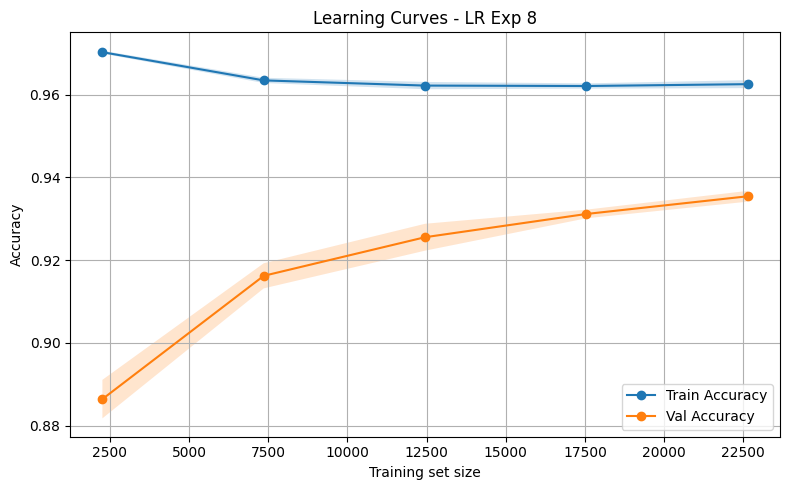

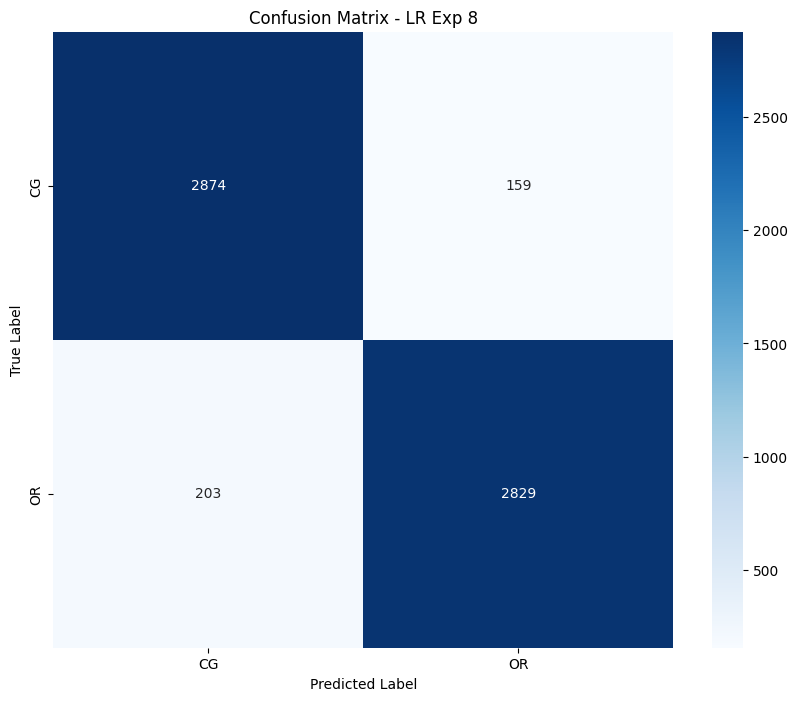

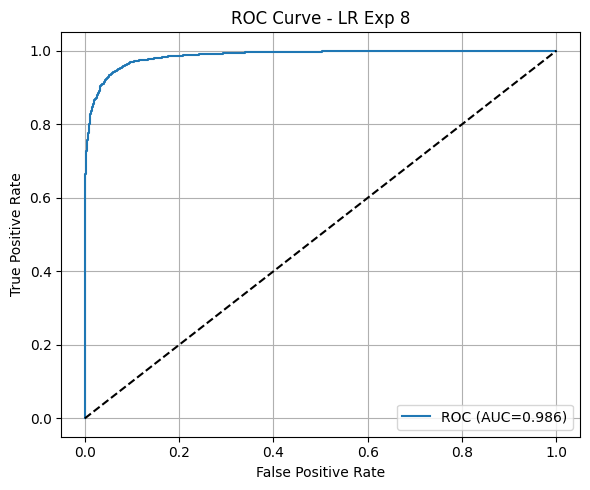

In [ ]:
# Learning curves, confusion matrix, and ROC for LR Experiment 8 (same test labels as other exps)
plot_lr_learning_curves(lr_exp8['model'], X_train_ml_8, y_train_ml_8, 'LR Exp 8')
plot_confusion_matrix(lr_exp8['confusion_matrix'], le_ml, 'LR Exp 8')
fpr8, tpr8, _ = roc_curve(y_test_ml_8, lr_exp8['y_test_proba'][:, 1])
plot_roc_curve(fpr8, tpr8, lr_exp8['roc_auc'], 'LR Exp 8')

### LR experiments comparison (ranked best to worst by test accuracy)

Table: Rank, Hyperparameters, Test Accuracy, Log Loss (test), Precision, Recall, F1, ROC-AUC, Confusion matrix.

In [ ]:
# Collect all 8 LR experiments and compute log loss on test set
lr_exps = [lr_exp1, lr_exp2, lr_exp3, lr_exp4, lr_exp5, lr_exp6, lr_exp7, lr_exp8]
y_test_list = [y_test_ml] * 7 + [y_test_ml_8]  # exp8 uses different test labels array (same split)

def fmt_cm(cm):
    return str(cm.tolist() if hasattr(cm, 'tolist') else cm)

def fmt_hp(hp):
    return ', '.join(f"{k}={v}" for k, v in sorted(hp.items()))

rows = []
for i, (exp, y_test) in enumerate(zip(lr_exps, y_test_list), start=1):
    proba = exp['y_test_proba'][:, 1]
    ll = log_loss(y_test, np.column_stack([1 - proba, proba]))
    rows.append({
        'Experiment': f'lr_exp{i}',
        'Hyperparameters': fmt_hp(exp['hyperparameters']),
        'Accuracy': exp['test_accuracy'],
        'Log Loss': ll,
        'Precision': exp['precision'],
        'Recall': exp['recall'],
        'F1': exp['f1_score'],
        'ROC-AUC': exp['roc_auc'],
        'Confusion matrix': fmt_cm(exp['confusion_matrix']),
    })

lr_comparison = pd.DataFrame(rows).sort_values('Accuracy', ascending=False).reset_index(drop=True)
lr_comparison.insert(1, 'Rank', range(1, len(lr_comparison) + 1))
lr_comparison[['Experiment', 'Rank', 'Hyperparameters', 'Accuracy', 'Log Loss', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Confusion matrix']]

,Experiment,Rank,Hyperparameters,Accuracy,Log Loss,Precision,Recall,F1,ROC-AUC,Confusion matrix
0,lr_exp8,1,"C=0.95, class_weight=balanced, max_iter=1000, ...",0.940313,0.206765,0.946787,0.933047,0.939867,0.985941,"[[2874, 159], [203, 2829]]"
1,lr_exp6,2,"C=1.0, class_weight=balanced, max_iter=1000, s...",0.936851,0.212577,0.947013,0.925462,0.936113,0.983785,"[[2876, 157], [226, 2806]]"
2,lr_exp7,3,"C=0.95, class_weight=balanced, max_iter=1000, ...",0.936851,0.214348,0.947617,0.924802,0.936071,0.983893,"[[2878, 155], [228, 2804]]"
3,lr_exp1,4,"C=1.0, class_weight=balanced, max_iter=1000, s...",0.936521,0.212405,0.946977,0.924802,0.935758,0.983869,"[[2876, 157], [228, 2804]]"
4,lr_exp4,5,"C=0.9, class_weight=balanced, max_iter=1000, s...",0.935037,0.217790,0.945307,0.923483,0.934268,0.983414,"[[2871, 162], [232, 2800]]"
5,lr_exp3,6,"C=0.8, class_weight=balanced, max_iter=1000, s...",0.933388,0.223997,0.944821,0.920515,0.932509,0.982893,"[[2870, 163], [241, 2791]]"
6,lr_exp2,7,"C=0.5, class_weight=balanced, max_iter=1000, s...",0.928607,0.251800,0.941857,0.913588,0.927507,0.980322,"[[2862, 171], [262, 2770]]"
7,lr_exp5,8,"C=1.0, class_weight=balanced, max_iter=1000, p...",0.919868,0.208864,0.930068,0.907982,0.918892,0.975869,"[[2826, 207], [279, 2753]]"


## 8. Deep Learning: BiLSTM for Fake Review Detection

In [ ]:
def evaluate_dl_experiment(dl_exp, experiment_name):
    """Print evaluation summary for a DL experiment (same style as LR experiments)."""
    print(f"\n{'='*60}\nExperiment: {experiment_name}\n{'='*60}\n\nHyperparameters:")
    for k, v in dl_exp['hyperparameters'].items():
        print(f"  {k}: {v}")
    print("\nValidation Metrics:")
    print(f"  Val Loss: {dl_exp.get('val_loss', 'N/A')}")
    print(f"  Val Accuracy: {dl_exp['val_accuracy']:.4f}")
    print(f"  Val Precision: {dl_exp.get('val_precision', 0):.4f}")
    print(f"  Val Recall: {dl_exp.get('val_recall', 0):.4f}")
    print("\nTest Metrics:")
    print(f"  Test Loss: {dl_exp.get('test_loss', 'N/A')}")
    print(f"  Test Accuracy: {dl_exp['test_accuracy']:.4f}")
    print(f"  Test Precision: {dl_exp['precision']:.4f}")
    print(f"  Test Recall: {dl_exp['recall']:.4f}")
    print(f"\nTest F1: {dl_exp['f1_score']:.4f}  ROC-AUC: {dl_exp['roc_auc']:.4f}")
    print("\nConfusion matrix (test):\n", dl_exp['confusion_matrix'])
    return dl_exp

### Experiment 1: Baseline BiLSTM

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 172s 190ms/step - accuracy: 0.8970 - loss: 0.2406 - val_accuracy: 0.9459 - val_loss: 0.1513 - learning_rate: 0.0010
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 205s 232ms/step - accuracy: 0.9666 - loss: 0.0917 - val_accuracy: 0.9434 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9776 - loss: 0.0641
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
885/885 ━━━━━━━━━━━━━━━━━━━━ 297s 335ms/step - accuracy: 0.9811 - loss: 0.0560 - val_accuracy: 0.9495 - val_loss: 0.1777 - learning_rate: 0.0010
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 222s 222ms/step - accuracy: 0.9916 - loss: 0.0261 - val_accuracy: 0.9426 - val_loss: 0.2035 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation set
--- BiLSTM Val ---
Accuracy: 0.9459  Precision: 0.9741  Recall: 0.9163  F1: 0.9443  ROC-AUC: 0.9874
Confusion matrix:
 [[

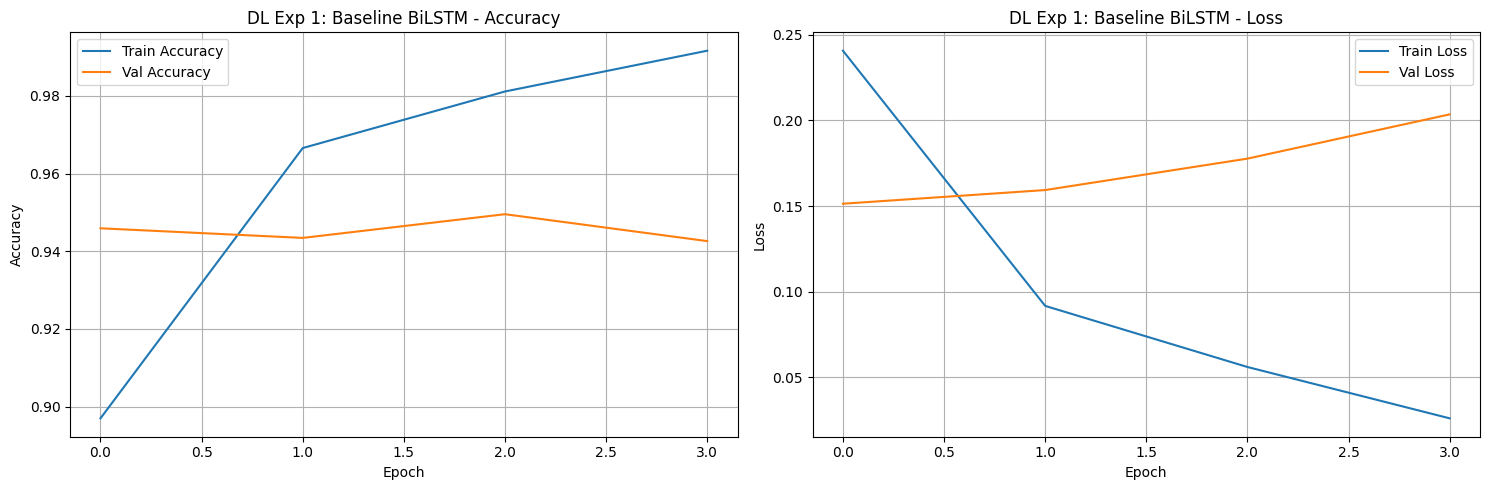

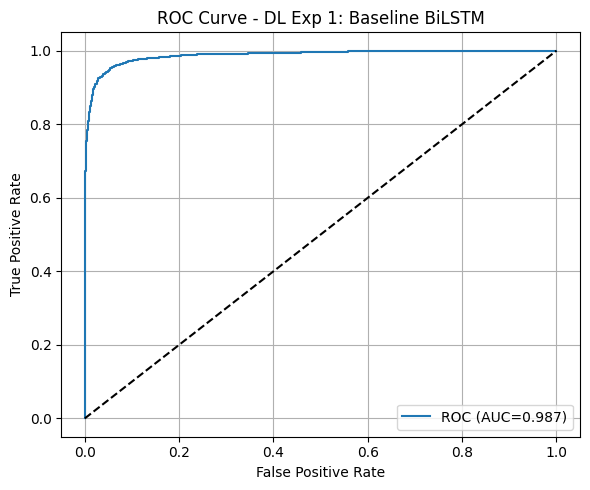

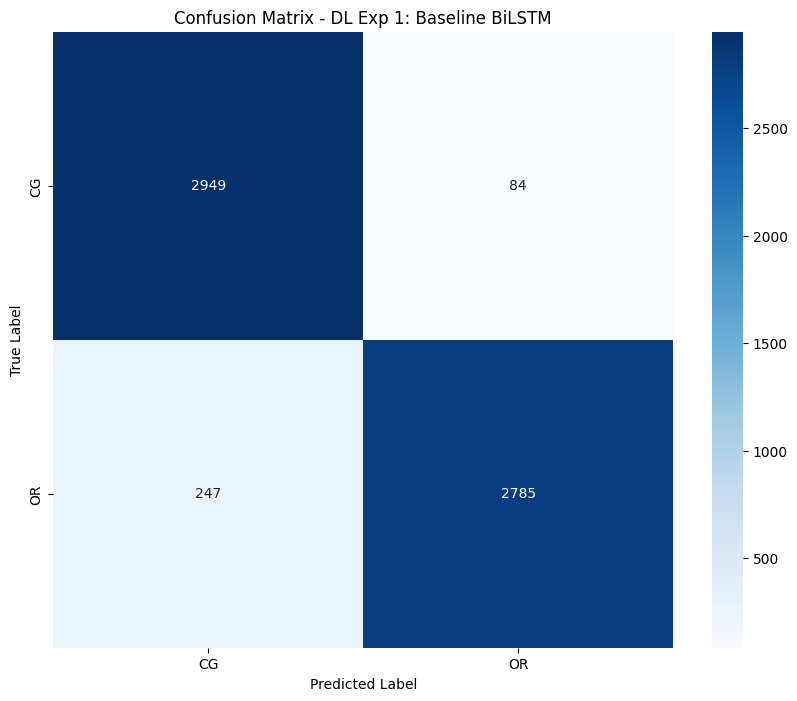

In [ ]:
# BiLSTM: build model, create datasets, class_weight, train, evaluate
dl_model = build_bilstm_model(vocab_size, max_len, embedding_dim=128, lstm_units=64, dropout_rate=0.4)
train_ds = create_tf_dataset(X_train_dl, y_train_dl, batch_size=32)
val_ds = create_tf_dataset(X_val_dl, y_val_dl, batch_size=32, shuffle=False)
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight('balanced', classes=np.unique(y_train_dl), y=y_train_dl)
class_weight_dl = dict(enumerate(cw))
dl_results = train_bilstm(dl_model, train_ds, val_ds, class_weight=class_weight_dl, learning_rate=1e-3, epochs=20, patience=3, verbose=1)
# Evaluate on validation and test
test_ds = create_tf_dataset(X_test_dl, y_test_dl, batch_size=32, shuffle=False)
y_val_pred_dl = (dl_results['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl = (dl_results['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl = dl_results['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl = dl_results['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics = evaluate_binary_clf(y_val_dl, y_val_pred_dl, np.column_stack([1 - y_val_proba_dl, y_val_proba_dl]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics = evaluate_binary_clf(y_test_dl, y_test_pred_dl, np.column_stack([1 - y_test_proba_dl, y_test_proba_dl]), "BiLSTM Test")
# Build dl_exp1 (same structure as lr_exp1) for comparison and reporting
test_loss, _ = dl_results['model'].evaluate(test_ds, verbose=0)
dl_exp1 = {
    'model': dl_results['model'],
    'history': dl_results['history'],
    'y_val_pred': y_val_pred_dl,
    'y_test_pred': y_test_pred_dl,
    'y_val_proba': y_val_proba_dl,
    'y_test_proba': y_test_proba_dl,
    'val_accuracy': dl_val_metrics['accuracy'],
    'test_accuracy': dl_test_metrics['accuracy'],
    'val_loss': float(dl_results.get('val_loss', dl_results['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss),
    'val_precision': dl_val_metrics['precision'],
    'val_recall': dl_val_metrics['recall'],
    'precision': dl_test_metrics['precision'],
    'recall': dl_test_metrics['recall'],
    'f1_score': dl_test_metrics['f1'],
    'roc_auc': dl_test_metrics['roc_auc'],
    'confusion_matrix': dl_test_metrics['confusion_matrix'],
    'hyperparameters': {'learning_rate': 1e-3, 'optimizer': 'adam', 'epochs': 20, 'patience': 3, 'dropout_rate': 0.4},
}
evaluate_dl_experiment(dl_exp1, 'DL Experiment 1: Baseline')
# Learning curves
plot_learning_curves(dl_results['history'], 'DL Exp 1: Baseline BiLSTM')
# ROC and confusion matrix (using shared plot functions)
fpr_dl, tpr_dl, _ = roc_curve(y_test_dl, dl_exp1['y_test_proba'])
plot_roc_curve(fpr_dl, tpr_dl, dl_exp1['roc_auc'], 'DL Exp 1: Baseline BiLSTM')
plot_confusion_matrix(dl_exp1['confusion_matrix'], le_ml, 'DL Exp 1: Baseline BiLSTM')

## 9. (Optional) Functional API

In [ ]:
# Same BiLSTM architecture using Functional API (required for assignment)
inputs = layers.Input(shape=(max_len,))
x = layers.Embedding(vocab_size, 128, input_length=max_len)(inputs)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
func_model = models.Model(inputs=inputs, outputs=outputs)
func_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
func_model.summary()


**DL Experiment 1 – Performance interpretation**

- **Training dynamics:** Learning curves show clear **overfitting**. Train accuracy rises sharply (≈0.90 → ≈0.99) while validation accuracy plateaus then dips (≈0.946 → ≈0.942). Train loss falls (≈0.24 → ≈0.03) while **validation loss increases** after epoch 1 (≈0.15 → ≈0.20). The model fits the training set very well but generalizes worse as training continues. Early stopping correctly restores weights from **epoch 1** (best validation loss).

- **Test performance (best checkpoint, epoch 1):** Strong discriminative performance: **test accuracy 94.54%**, **precision 0.9707**, **recall 0.9185**, **F1 0.9439**, **ROC-AUC 0.987**. The ROC curve sits well above the diagonal (AUC=0.987), so the model separates the two classes very well.

- **Confusion matrix:** True Negatives 2949, False Positives 84, False Negatives 247, True Positives 2785. The model is more likely to **miss fake reviews (247 FN)** than to wrongly flag genuine ones (84 FP). So recall (catching OR/fake) has more room to improve than precision.

- **Summary:** DL Exp 1 is a strong baseline but overfits quickly. Improving regularization and training stability should allow better generalization and potentially higher validation/test performance. **DL Exp 2** below uses stronger dropout and a lower learning rate to reduce overfitting and aim for better validation and test metrics.

### Experiment 2: Reduced overfitting (higher dropout, lower learning rate)

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 153s 167ms/step - accuracy: 0.8742 - loss: 0.2800 - val_accuracy: 0.9428 - val_loss: 0.1532 - learning_rate: 5.0000e-04
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 149s 168ms/step - accuracy: 0.9580 - loss: 0.1165 - val_accuracy: 0.9481 - val_loss: 0.1424 - learning_rate: 5.0000e-04
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 175s 198ms/step - accuracy: 0.9751 - loss: 0.0737 - val_accuracy: 0.9420 - val_loss: 0.1634 - learning_rate: 5.0000e-04
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9791 - loss: 0.0599
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
885/885 ━━━━━━━━━━━━━━━━━━━━ 173s 196ms/step - accuracy: 0.9834 - loss: 0.0508 - val_accuracy: 0.9489 - val_loss: 0.1626 - learning_rate: 5.0000e-04
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 160s 181ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.9471 - val_loss: 0.2073 - learning_rate: 2.5000e-04
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 177m

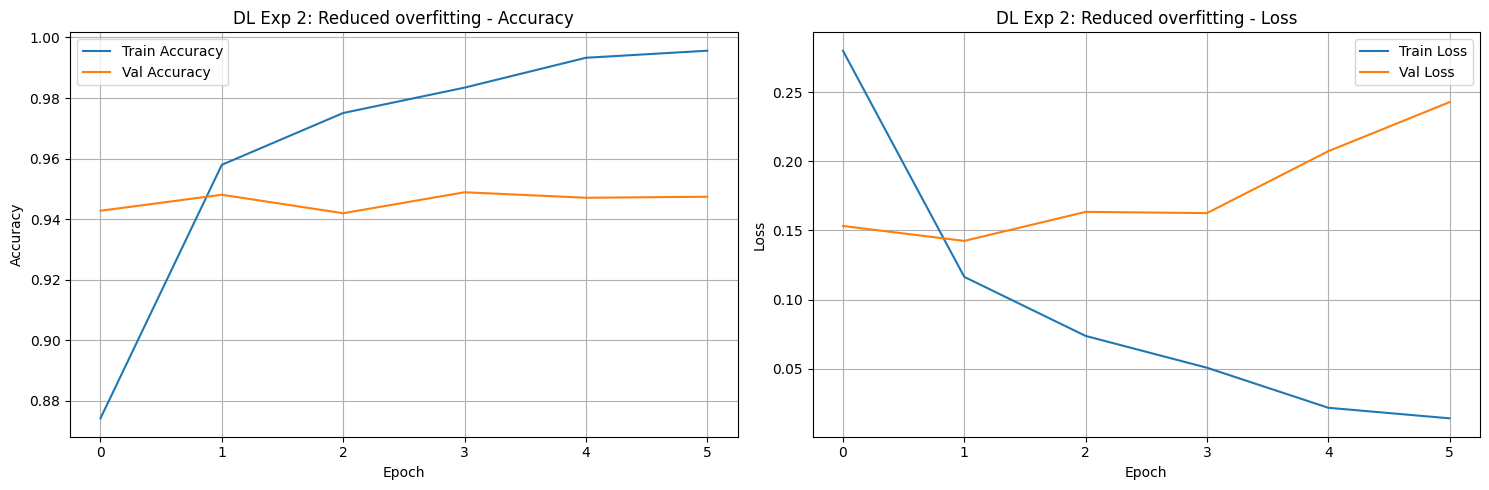

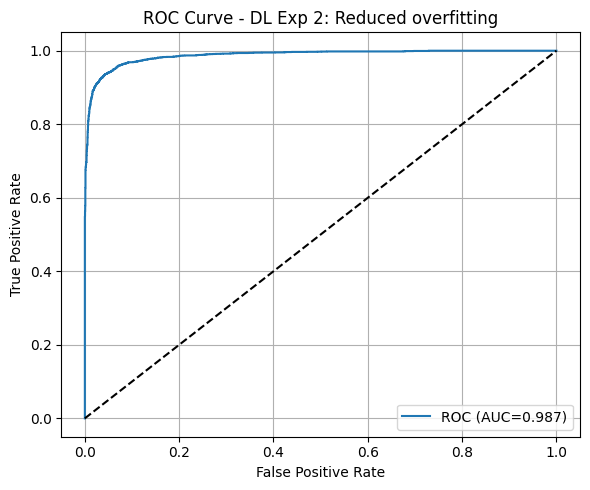

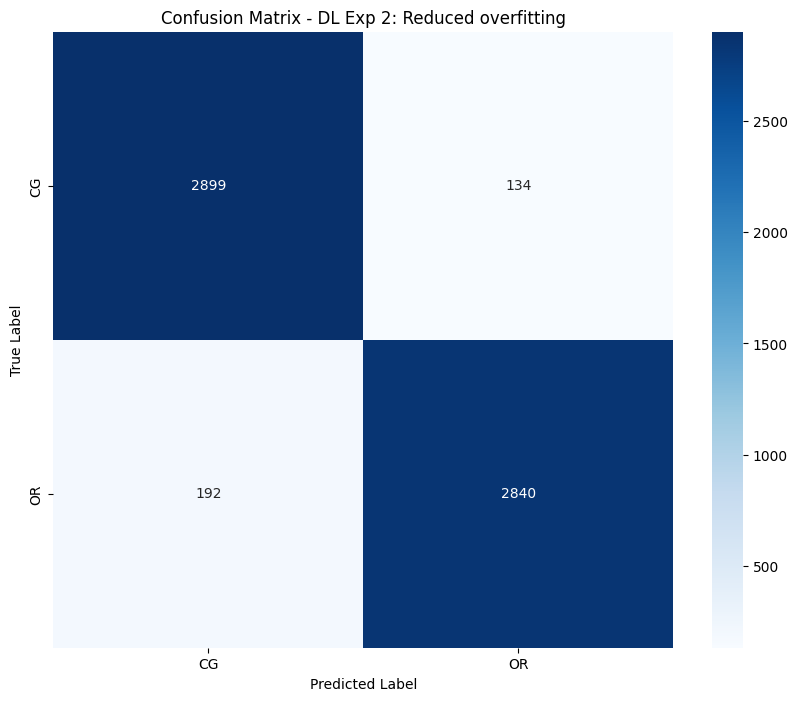

In [ ]:
# dl_exp2: stronger regularization (dropout 0.5) and lower LR (5e-4), more patience (4) to reduce overfitting
dl_model2 = build_bilstm_model(vocab_size, max_len, embedding_dim=128, lstm_units=64, dropout_rate=0.5)
dl_results2 = train_bilstm(dl_model2, train_ds, val_ds, class_weight=class_weight_dl, learning_rate=5e-4, epochs=20, patience=4, verbose=1)
# Evaluate on validation and test
y_val_pred_dl2 = (dl_results2['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl2 = (dl_results2['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl2 = dl_results2['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl2 = dl_results2['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics2 = evaluate_binary_clf(y_val_dl, y_val_pred_dl2, np.column_stack([1 - y_val_proba_dl2, y_val_proba_dl2]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics2 = evaluate_binary_clf(y_test_dl, y_test_pred_dl2, np.column_stack([1 - y_test_proba_dl2, y_test_proba_dl2]), "BiLSTM Test")
test_loss2, _ = dl_results2['model'].evaluate(test_ds, verbose=0)
dl_exp2 = {
    'model': dl_results2['model'],
    'history': dl_results2['history'],
    'y_val_pred': y_val_pred_dl2,
    'y_test_pred': y_test_pred_dl2,
    'y_val_proba': y_val_proba_dl2,
    'y_test_proba': y_test_proba_dl2,
    'val_accuracy': dl_val_metrics2['accuracy'],
    'test_accuracy': dl_test_metrics2['accuracy'],
    'val_loss': float(dl_results2.get('val_loss', dl_results2['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss2),
    'val_precision': dl_val_metrics2['precision'],
    'val_recall': dl_val_metrics2['recall'],
    'precision': dl_test_metrics2['precision'],
    'recall': dl_test_metrics2['recall'],
    'f1_score': dl_test_metrics2['f1'],
    'roc_auc': dl_test_metrics2['roc_auc'],
    'confusion_matrix': dl_test_metrics2['confusion_matrix'],
    'hyperparameters': {'learning_rate': 5e-4, 'optimizer': 'adam', 'epochs': 20, 'patience': 4, 'dropout_rate': 0.5},
}
evaluate_dl_experiment(dl_exp2, 'DL Experiment 2: Reduced overfitting')
plot_learning_curves(dl_results2['history'], 'DL Exp 2: Reduced overfitting')
fpr_dl2, tpr_dl2, _ = roc_curve(y_test_dl, dl_exp2['y_test_proba'])
plot_roc_curve(fpr_dl2, tpr_dl2, dl_exp2['roc_auc'], 'DL Exp 2: Reduced overfitting')
plot_confusion_matrix(dl_exp2['confusion_matrix'], le_ml, 'DL Exp 2: Reduced overfitting')

**DL Experiment 2 – Performance interpretation (vs Exp 1)**

- **Training dynamics:** Learning curves still show **overfitting** (train accuracy and loss keep improving while val accuracy plateaus and val loss rises after epoch 2), but the best validation point is **better** than in Exp 1. Early stopping restores weights from **epoch 2** (val loss 0.1424) instead of epoch 1. So the lower learning rate (5e-4) and higher dropout (0.5) allowed a slightly better validation minimum before overfitting.

- **Comparison with dl_exp1:** Exp 2 improves on Exp 1 on most metrics: **test accuracy 94.62%** (vs 94.54%), **test F1 0.9457** (vs 0.9439), **test recall 0.9367** (vs 0.9185). Recall gains are large: **55 fewer false negatives** (192 vs 247), so more fake (OR) reviews are detected. **Precision is a bit lower** (0.9549 vs 0.9707) with **50 more false positives** (134 vs 84). ROC-AUC is effectively the same (~0.987). So Exp 2 trades a small amount of precision for clearly better recall and a small gain in accuracy and F1.

- **Confusion matrix:** [[2899, 134], [192, 2840]] — stronger on catching OR (higher TP, lower FN) and slightly more CG misclassified as OR (higher FP). For a task where missing fakes is costly, Exp 2 is an improvement over Exp 1.

- **Summary:** Exp 2’s stronger regularization and lower learning rate gave a better validation checkpoint and better test recall/F1/accuracy. Overfitting is still present; **dl_exp3** below uses a smaller model (fewer LSTM units and embedding dim) and slightly more dropout to further limit overfitting and aim for better validation and test performance.

### Experiment 3: Smaller capacity + stronger regularization (less overfitting)

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 118s 127ms/step - accuracy: 0.8369 - loss: 0.3336 - val_accuracy: 0.9286 - val_loss: 0.1886 - learning_rate: 3.0000e-04
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 115s 130ms/step - accuracy: 0.9516 - loss: 0.1311 - val_accuracy: 0.9489 - val_loss: 0.1360 - learning_rate: 3.0000e-04
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 126s 143ms/step - accuracy: 0.9709 - loss: 0.0822 - val_accuracy: 0.9434 - val_loss: 0.1615 - learning_rate: 3.0000e-04
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9787 - loss: 0.0656
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
885/885 ━━━━━━━━━━━━━━━━━━━━ 134s 152ms/step - accuracy: 0.9802 - loss: 0.0590 - val_accuracy: 0.9505 - val_loss: 0.1539 - learning_rate: 3.0000e-04
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 154s 174ms/step - accuracy: 0.9891 - loss: 0.0347 - val_accuracy: 0.9540 - val_loss: 0.1672 - learning_rate: 1.5000e-04
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 153m

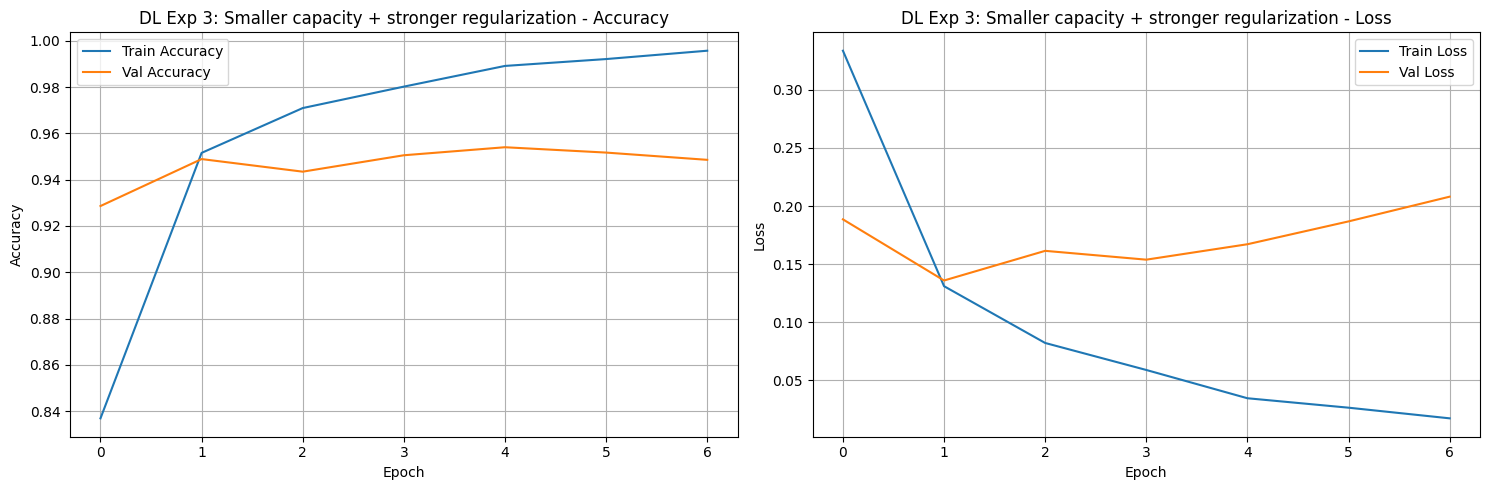

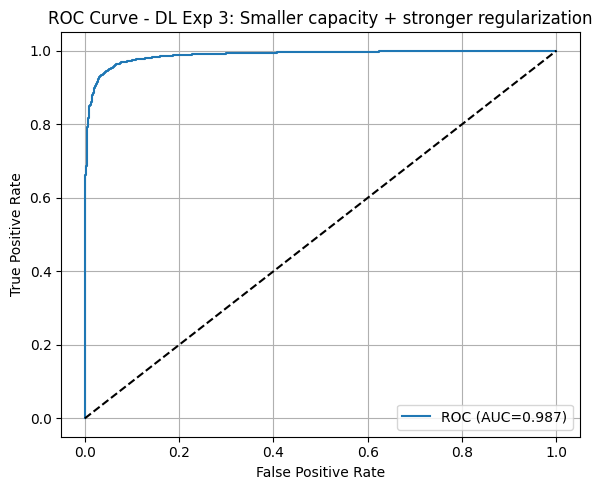

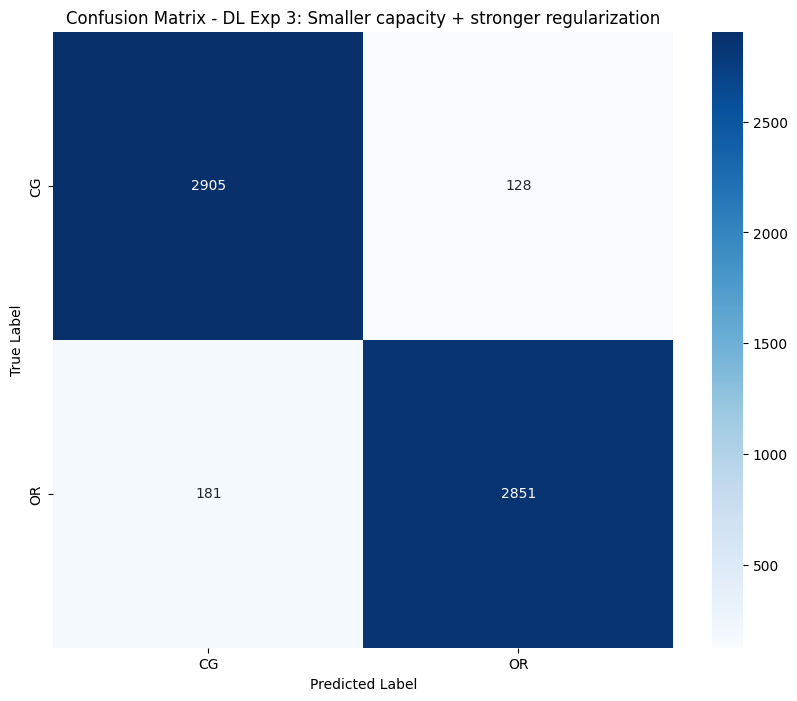

In [ ]:
# dl_exp3: smaller model (embedding_dim=96, lstm_units=48), dropout=0.55, LR=3e-4, patience=5
dl_model3 = build_bilstm_model(vocab_size, max_len, embedding_dim=96, lstm_units=48, dropout_rate=0.55)
dl_results3 = train_bilstm(dl_model3, train_ds, val_ds, class_weight=class_weight_dl, learning_rate=3e-4, epochs=20, patience=5, verbose=1)
# Evaluate on validation and test
y_val_pred_dl3 = (dl_results3['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl3 = (dl_results3['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl3 = dl_results3['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl3 = dl_results3['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics3 = evaluate_binary_clf(y_val_dl, y_val_pred_dl3, np.column_stack([1 - y_val_proba_dl3, y_val_proba_dl3]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics3 = evaluate_binary_clf(y_test_dl, y_test_pred_dl3, np.column_stack([1 - y_test_proba_dl3, y_test_proba_dl3]), "BiLSTM Test")
test_loss3, _ = dl_results3['model'].evaluate(test_ds, verbose=0)
dl_exp3 = {
    'model': dl_results3['model'],
    'history': dl_results3['history'],
    'y_val_pred': y_val_pred_dl3,
    'y_test_pred': y_test_pred_dl3,
    'y_val_proba': y_val_proba_dl3,
    'y_test_proba': y_test_proba_dl3,
    'val_accuracy': dl_val_metrics3['accuracy'],
    'test_accuracy': dl_test_metrics3['accuracy'],
    'val_loss': float(dl_results3.get('val_loss', dl_results3['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss3),
    'val_precision': dl_val_metrics3['precision'],
    'val_recall': dl_val_metrics3['recall'],
    'precision': dl_test_metrics3['precision'],
    'recall': dl_test_metrics3['recall'],
    'f1_score': dl_test_metrics3['f1'],
    'roc_auc': dl_test_metrics3['roc_auc'],
    'confusion_matrix': dl_test_metrics3['confusion_matrix'],
    'hyperparameters': {'learning_rate': 3e-4, 'optimizer': 'adam', 'epochs': 20, 'patience': 5, 'dropout_rate': 0.55, 'embedding_dim': 96, 'lstm_units': 48},
}
evaluate_dl_experiment(dl_exp3, 'DL Experiment 3: Smaller capacity + stronger regularization')
plot_learning_curves(dl_results3['history'], 'DL Exp 3: Smaller capacity + stronger regularization')
fpr_dl3, tpr_dl3, _ = roc_curve(y_test_dl, dl_exp3['y_test_proba'])
plot_roc_curve(fpr_dl3, tpr_dl3, dl_exp3['roc_auc'], 'DL Exp 3: Smaller capacity + stronger regularization')
plot_confusion_matrix(dl_exp3['confusion_matrix'], le_ml, 'DL Exp 3: Smaller capacity + stronger regularization')

**DL Experiment 3 – Performance interpretation (vs Exp 1)**

- **Training dynamics:** Learning curves still show **overfitting** (train accuracy and loss keep improving while validation loss rises after epoch 2), but the **best validation point is the best so far**. Early stopping restores weights from **epoch 2** (val loss **0.1360**). The smaller model (embedding_dim=96, lstm_units=48) and stronger regularization (dropout 0.55, LR 3e-4) give a lower validation loss at the best epoch than both Exp 1 and Exp 2.

- **Comparison with dl_exp1:** Exp 3 improves on Exp 1 across the board: **test accuracy 94.91%** (vs 94.54%), **test F1 0.9486** (vs 0.9439), **test recall 0.9403** (vs 0.9185), **test precision 0.9570** (vs 0.9707). So Exp 3 has **higher recall** (66 fewer false negatives: 181 vs 247) with only a **modest drop in precision** (44 more false positives: 128 vs 84). ROC-AUC is **0.9874** (same as Exp 1). The confusion matrix [[2905, 128], [181, 2851]] shows a better balance: fewer missed OR (181 FN) and only slightly more CG predicted as OR (128 FP) than Exp 1.

- **Vs Exp 2:** Exp 3 also beats Exp 2 on test accuracy (94.91% vs 94.62%), F1 (0.9486 vs 0.9457), recall (0.9403 vs 0.9367), and precision (0.9570 vs 0.9549), with **fewer false negatives** (181 vs 192) and **fewer false positives** (128 vs 134). So the smaller, more regularized model in Exp 3 generalizes best among the first three experiments.

- **Summary:** Reducing capacity (96/48) and using stronger dropout (0.55) and lower LR (3e-4) gave the best validation checkpoint and the best test metrics so far. **dl_exp4** below pushes regularization slightly further (higher dropout, lower LR, more patience) to see if we can improve again.

### Experiment 4: Stronger regularization (higher dropout, lower LR, more patience)

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 130s 138ms/step - accuracy: 0.7915 - loss: 0.4170 - val_accuracy: 0.9190 - val_loss: 0.2093 - learning_rate: 2.0000e-04
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 129s 146ms/step - accuracy: 0.9382 - loss: 0.1663 - val_accuracy: 0.9430 - val_loss: 0.1559 - learning_rate: 2.0000e-04
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 134s 152ms/step - accuracy: 0.9605 - loss: 0.1078 - val_accuracy: 0.9461 - val_loss: 0.1478 - learning_rate: 2.0000e-04
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 140s 158ms/step - accuracy: 0.9736 - loss: 0.0786 - val_accuracy: 0.9481 - val_loss: 0.1526 - learning_rate: 2.0000e-04
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9794 - loss: 0.0649
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
885/885 ━━━━━━━━━━━━━━━━━━━━ 132s 149ms/step - accuracy: 0.9795 - loss: 0.0637 - val_accuracy: 0.9482 - val_loss: 0.1758 - learning_rate: 2.0000e-04
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 126s 14

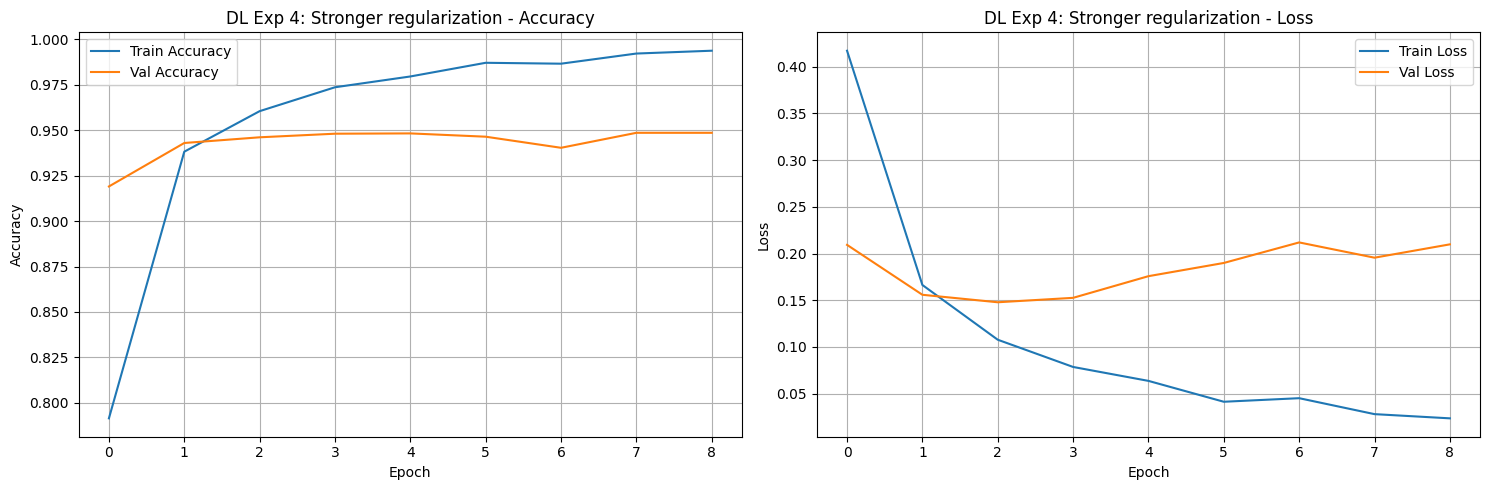

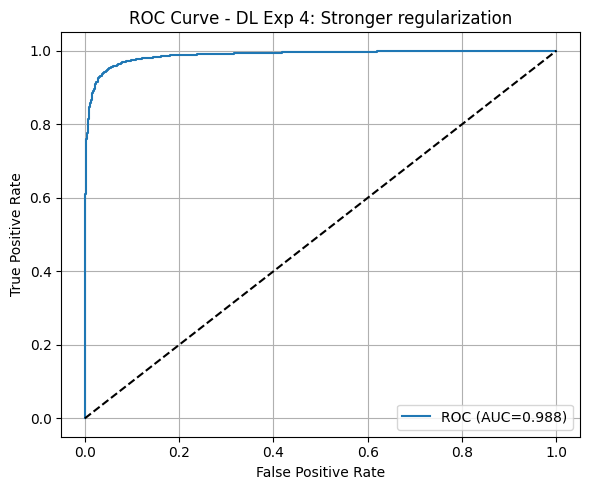

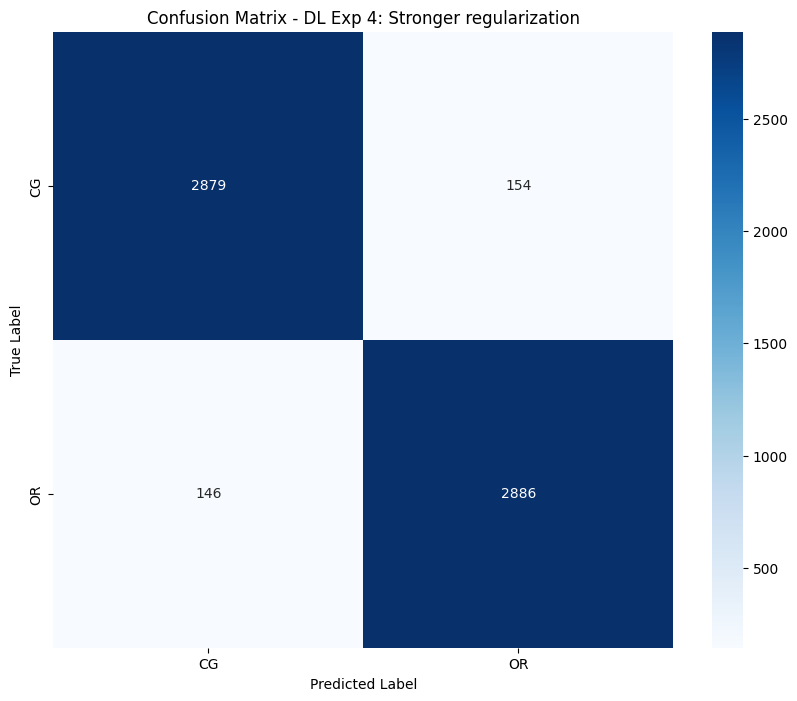

In [ ]:
# dl_exp4: same capacity as exp3 (96/48), dropout=0.6, LR=2e-4, patience=6
dl_model4 = build_bilstm_model(vocab_size, max_len, embedding_dim=96, lstm_units=48, dropout_rate=0.6)
dl_results4 = train_bilstm(dl_model4, train_ds, val_ds, class_weight=class_weight_dl, learning_rate=2e-4, epochs=20, patience=6, verbose=1)
# Evaluate on validation and test
y_val_pred_dl4 = (dl_results4['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl4 = (dl_results4['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl4 = dl_results4['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl4 = dl_results4['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics4 = evaluate_binary_clf(y_val_dl, y_val_pred_dl4, np.column_stack([1 - y_val_proba_dl4, y_val_proba_dl4]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics4 = evaluate_binary_clf(y_test_dl, y_test_pred_dl4, np.column_stack([1 - y_test_proba_dl4, y_test_proba_dl4]), "BiLSTM Test")
test_loss4, _ = dl_results4['model'].evaluate(test_ds, verbose=0)
dl_exp4 = {
    'model': dl_results4['model'],
    'history': dl_results4['history'],
    'y_val_pred': y_val_pred_dl4,
    'y_test_pred': y_test_pred_dl4,
    'y_val_proba': y_val_proba_dl4,
    'y_test_proba': y_test_proba_dl4,
    'val_accuracy': dl_val_metrics4['accuracy'],
    'test_accuracy': dl_test_metrics4['accuracy'],
    'val_loss': float(dl_results4.get('val_loss', dl_results4['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss4),
    'val_precision': dl_val_metrics4['precision'],
    'val_recall': dl_val_metrics4['recall'],
    'precision': dl_test_metrics4['precision'],
    'recall': dl_test_metrics4['recall'],
    'f1_score': dl_test_metrics4['f1'],
    'roc_auc': dl_test_metrics4['roc_auc'],
    'confusion_matrix': dl_test_metrics4['confusion_matrix'],
    'hyperparameters': {'learning_rate': 2e-4, 'optimizer': 'adam', 'epochs': 20, 'patience': 6, 'dropout_rate': 0.6, 'embedding_dim': 96, 'lstm_units': 48},
}
evaluate_dl_experiment(dl_exp4, 'DL Experiment 4: Stronger regularization')
plot_learning_curves(dl_results4['history'], 'DL Exp 4: Stronger regularization')
fpr_dl4, tpr_dl4, _ = roc_curve(y_test_dl, dl_exp4['y_test_proba'])
plot_roc_curve(fpr_dl4, tpr_dl4, dl_exp4['roc_auc'], 'DL Exp 4: Stronger regularization')
plot_confusion_matrix(dl_exp4['confusion_matrix'], le_ml, 'DL Exp 4: Stronger regularization')

**DL Experiment 4 – Performance interpretation (vs Exp 1–3)**

- **Test set:** Exp 4 achieves the **best test metrics so far**: test accuracy **95.05%**, test F1 **0.9506**, test recall **0.9518**, and ROC-AUC **0.9876**. Compared to Exp 1–3, it has the **lowest false negatives** (146 vs 181–247) and a more balanced precision/recall (0.9493 vs 0.9518). The confusion matrix [[2879, 154], [146, 2886]] shows strong performance on both classes.

- **Validation and overfitting:** Despite stronger regularization (dropout 0.6, LR 2e-4), the **learning curves still show clear overfitting**: training accuracy and loss keep improving while validation loss reaches a minimum around epoch 2–3 and then **increases** through later epochs. Early stopping correctly restores weights from **epoch 3** (val loss 0.1478). So the model that is evaluated is the one from epoch 3; beyond that, the model is fitting the training set more than it is generalizing.

- **Comparison with Exp 1–3:** Exp 4 beats all previous experiments on test accuracy, F1, and recall. Versus Exp 3 specifically: higher test accuracy (95.05% vs 94.91%), higher F1 (0.9506 vs 0.9486), higher recall (0.9518 vs 0.9403), with 35 fewer FN (146 vs 181) and 26 more FP (154 vs 128). So Exp 4 is the best so far on the test set, but **overfitting remains**—the gap between train and validation curves and the rising validation loss after the best epoch indicate we can still try to improve generalization. **dl_exp5** below uses a smaller model and even stronger regularization to reduce overfitting further while aiming to keep or improve test performance.

### Experiment 5: Smaller capacity + stronger regularization (reduce overfitting)

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 105s 112ms/step - accuracy: 0.7306 - loss: 0.5030 - val_accuracy: 0.9133 - val_loss: 0.2444 - learning_rate: 1.0000e-04
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 102s 115ms/step - accuracy: 0.9241 - loss: 0.2014 - val_accuracy: 0.9322 - val_loss: 0.1841 - learning_rate: 1.0000e-04
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 125s 141ms/step - accuracy: 0.9456 - loss: 0.1485 - val_accuracy: 0.9372 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 103s 116ms/step - accuracy: 0.9564 - loss: 0.1208 - val_accuracy: 0.9420 - val_loss: 0.1698 - learning_rate: 1.0000e-04
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 101s 114ms/step - accuracy: 0.9638 - loss: 0.1039 - val_accuracy: 0.9413 - val_loss: 0.1736 - learning_rate: 1.0000e-04
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9691 - loss: 0.0908
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
885/885 ━━━━━━━━━━━━━━━━━━━━ 96s 108

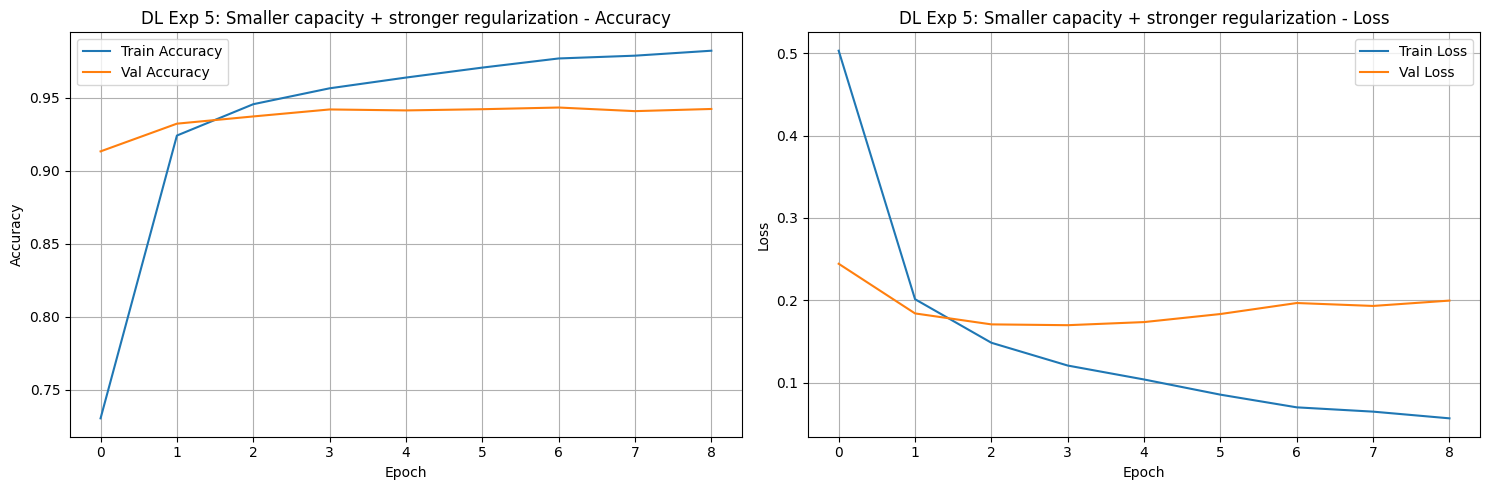

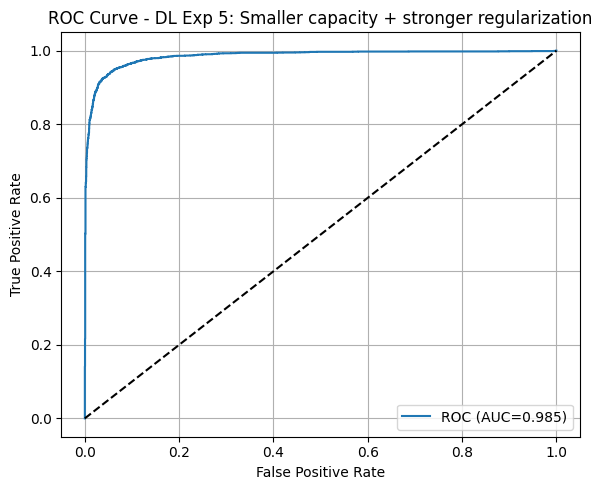

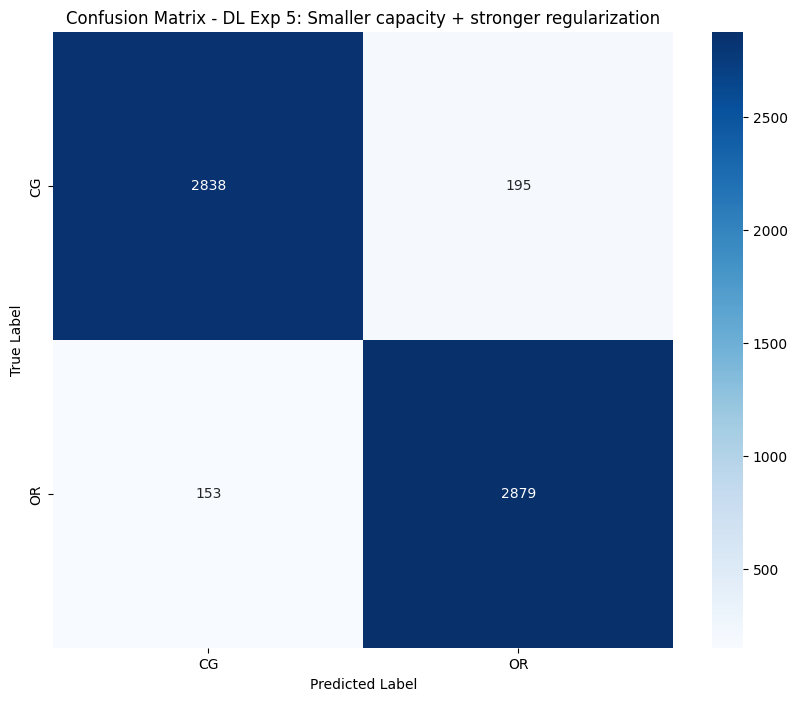

In [ ]:
# dl_exp5: smaller model (embedding_dim=64, lstm_units=32), dropout=0.65, LR=1e-4, patience=5 to reduce overfitting
dl_model5 = build_bilstm_model(vocab_size, max_len, embedding_dim=64, lstm_units=32, dropout_rate=0.65)
dl_results5 = train_bilstm(dl_model5, train_ds, val_ds, class_weight=class_weight_dl, learning_rate=1e-4, epochs=20, patience=5, verbose=1)
# Evaluate on validation and test
y_val_pred_dl5 = (dl_results5['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl5 = (dl_results5['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl5 = dl_results5['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl5 = dl_results5['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics5 = evaluate_binary_clf(y_val_dl, y_val_pred_dl5, np.column_stack([1 - y_val_proba_dl5, y_val_proba_dl5]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics5 = evaluate_binary_clf(y_test_dl, y_test_pred_dl5, np.column_stack([1 - y_test_proba_dl5, y_test_proba_dl5]), "BiLSTM Test")
test_loss5, _ = dl_results5['model'].evaluate(test_ds, verbose=0)
dl_exp5 = {
    'model': dl_results5['model'],
    'history': dl_results5['history'],
    'y_val_pred': y_val_pred_dl5,
    'y_test_pred': y_test_pred_dl5,
    'y_val_proba': y_val_proba_dl5,
    'y_test_proba': y_test_proba_dl5,
    'val_accuracy': dl_val_metrics5['accuracy'],
    'test_accuracy': dl_test_metrics5['accuracy'],
    'val_loss': float(dl_results5.get('val_loss', dl_results5['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss5),
    'val_precision': dl_val_metrics5['precision'],
    'val_recall': dl_val_metrics5['recall'],
    'precision': dl_test_metrics5['precision'],
    'recall': dl_test_metrics5['recall'],
    'f1_score': dl_test_metrics5['f1'],
    'roc_auc': dl_test_metrics5['roc_auc'],
    'confusion_matrix': dl_test_metrics5['confusion_matrix'],
    'hyperparameters': {'learning_rate': 1e-4, 'optimizer': 'adam', 'epochs': 20, 'patience': 5, 'dropout_rate': 0.65, 'embedding_dim': 64, 'lstm_units': 32},
}
evaluate_dl_experiment(dl_exp5, 'DL Experiment 5: Smaller capacity + stronger regularization')
plot_learning_curves(dl_results5['history'], 'DL Exp 5: Smaller capacity + stronger regularization')
fpr_dl5, tpr_dl5, _ = roc_curve(y_test_dl, dl_exp5['y_test_proba'])
plot_roc_curve(fpr_dl5, tpr_dl5, dl_exp5['roc_auc'], 'DL Exp 5: Smaller capacity + stronger regularization')
plot_confusion_matrix(dl_exp5['confusion_matrix'], le_ml, 'DL Exp 5: Smaller capacity + stronger regularization')

**DL Experiment 5 – Performance interpretation (vs Exp 1–4)**

- **Test set:** Exp 5 has **lower test performance** than Exp 3 and Exp 4: test accuracy **94.26%**, F1 **0.9430**, ROC-AUC **0.9851**. Compared to Exp 4 (95.05% accuracy, F1 0.9506), Exp 5 loses about 0.8% accuracy and 0.007 F1. The confusion matrix [[2838, 195], [153, 2879]] shows **more false positives** (195 vs 154 in Exp 4) and similar false negatives (153 vs 146). So the smaller model (64/32) with stronger regularization (dropout 0.65, LR 1e-4) **reduced capacity too much** and underperformed on the test set relative to the best runs.

- **Overfitting:** The **learning curves still show overfitting**: training accuracy rises toward ~0.98 while validation accuracy plateaus around ~0.94; validation loss reaches a minimum around epoch 3–4 (**0.1698**) and then **increases** as training continues. Early stopping correctly restores weights from **epoch 4**. So overfitting is still present—the smaller model did not remove it, and the cost in test performance was significant.

- **Comparison with Exp 1–4:** Exp 5 is better than Exp 1 and Exp 2 on test accuracy and F1 but **worse than Exp 3 and Exp 4**. So the best test results so far remain Exp 4 (95.05%, F1 0.9506). For **dl_exp6** we keep the **capacity that worked** (Exp 4’s 96/48, dropout 0.6) and add a different regularizer—**smaller batch size (16)**—plus a slightly lower learning rate (1.5e-4), to try to reduce overfitting without sacrificing test performance.

### Experiment 6: Same capacity as Exp 4 + smaller batch size (regularization)

Epoch 1/20
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 198s 109ms/step - accuracy: 0.8243 - loss: 0.3595 - val_accuracy: 0.9240 - val_loss: 0.2026 - learning_rate: 1.5000e-04
Epoch 2/20
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 224s 127ms/step - accuracy: 0.9396 - loss: 0.1638 - val_accuracy: 0.9453 - val_loss: 0.1523 - learning_rate: 1.5000e-04
Epoch 3/20
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 245s 138ms/step - accuracy: 0.9603 - loss: 0.1142 - val_accuracy: 0.9416 - val_loss: 0.1588 - learning_rate: 1.5000e-04
Epoch 4/20
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9702 - loss: 0.0877
Epoch 4: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 232s 131ms/step - accuracy: 0.9708 - loss: 0.0880 - val_accuracy: 0.9453 - val_loss: 0.1581 - learning_rate: 1.5000e-04
Epoch 5/20
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 210s 119ms/step - accuracy: 0.9806 - loss: 0.0598 - val_accuracy: 0.9486 - val_loss: 0.1675 - learning_rate: 7.5000e-05
Epoch 6/20
1769/1769 ━━━━━━━━━━━━━━

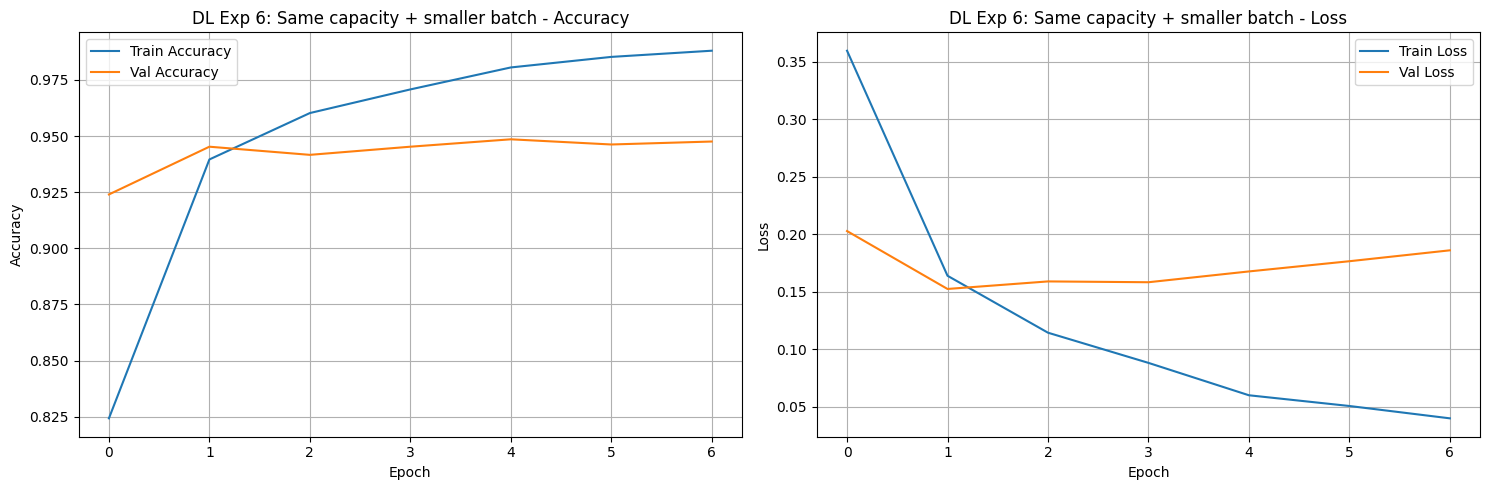

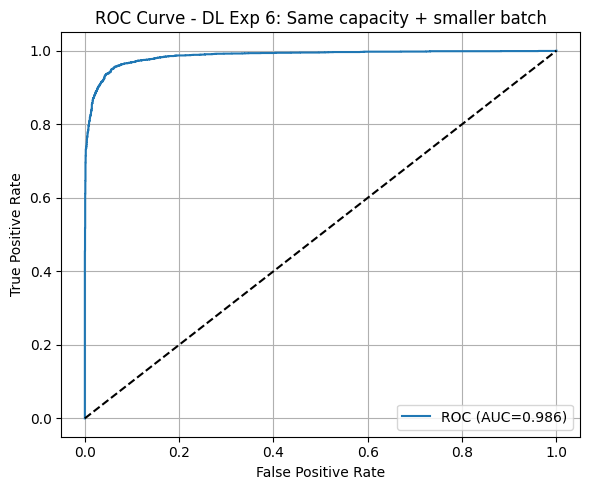

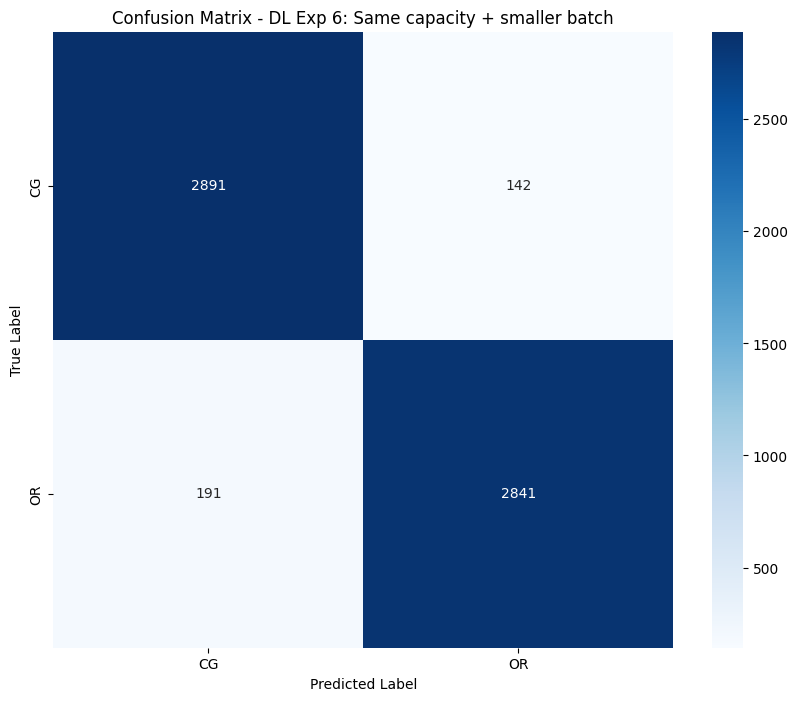

In [ ]:
# dl_exp6: same architecture as exp4 (96/48, dropout 0.6), train with batch_size=16 (regularization), LR=1.5e-4, patience=5
dl_model6 = build_bilstm_model(vocab_size, max_len, embedding_dim=96, lstm_units=48, dropout_rate=0.6)
train_ds_16 = create_tf_dataset(X_train_dl, y_train_dl, batch_size=16)
dl_results6 = train_bilstm(dl_model6, train_ds_16, val_ds, class_weight=class_weight_dl, learning_rate=1.5e-4, epochs=20, patience=5, verbose=1)
# Evaluate on validation and test (use same test_ds)
y_val_pred_dl6 = (dl_results6['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl6 = (dl_results6['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl6 = dl_results6['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl6 = dl_results6['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics6 = evaluate_binary_clf(y_val_dl, y_val_pred_dl6, np.column_stack([1 - y_val_proba_dl6, y_val_proba_dl6]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics6 = evaluate_binary_clf(y_test_dl, y_test_pred_dl6, np.column_stack([1 - y_test_proba_dl6, y_test_proba_dl6]), "BiLSTM Test")
test_loss6, _ = dl_results6['model'].evaluate(test_ds, verbose=0)
dl_exp6 = {
    'model': dl_results6['model'],
    'history': dl_results6['history'],
    'y_val_pred': y_val_pred_dl6,
    'y_test_pred': y_test_pred_dl6,
    'y_val_proba': y_val_proba_dl6,
    'y_test_proba': y_test_proba_dl6,
    'val_accuracy': dl_val_metrics6['accuracy'],
    'test_accuracy': dl_test_metrics6['accuracy'],
    'val_loss': float(dl_results6.get('val_loss', dl_results6['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss6),
    'val_precision': dl_val_metrics6['precision'],
    'val_recall': dl_val_metrics6['recall'],
    'precision': dl_test_metrics6['precision'],
    'recall': dl_test_metrics6['recall'],
    'f1_score': dl_test_metrics6['f1'],
    'roc_auc': dl_test_metrics6['roc_auc'],
    'confusion_matrix': dl_test_metrics6['confusion_matrix'],
    'hyperparameters': {'learning_rate': 1.5e-4, 'optimizer': 'adam', 'epochs': 20, 'patience': 5, 'dropout_rate': 0.6, 'embedding_dim': 96, 'lstm_units': 48, 'batch_size': 16},
}
evaluate_dl_experiment(dl_exp6, 'DL Experiment 6: Same capacity + smaller batch')
plot_learning_curves(dl_results6['history'], 'DL Exp 6: Same capacity + smaller batch')
fpr_dl6, tpr_dl6, _ = roc_curve(y_test_dl, dl_exp6['y_test_proba'])
plot_roc_curve(fpr_dl6, tpr_dl6, dl_exp6['roc_auc'], 'DL Exp 6: Same capacity + smaller batch')
plot_confusion_matrix(dl_exp6['confusion_matrix'], le_ml, 'DL Exp 6: Same capacity + smaller batch')

**DL Experiment 6 – Performance interpretation (vs Exp 1–5)**

- **Test set:** Exp 6 reaches test accuracy **94.51%**, F1 **0.9446**, ROC-AUC **0.9859** — better than Exp 1, 2, and 5 but **below Exp 3 and Exp 4**. The confusion matrix [[2891, 142], [191, 2841]] shows more false negatives (191) than Exp 4 (146) and similar false positives (142 vs 154). So training with a smaller batch (16) and slightly lower LR (1.5e-4) did not beat Exp 4’s test performance; it landed between Exp 2 and Exp 3.

- **Overfitting:** The **learning curves still show overfitting**: validation loss reaches a minimum at **epoch 2** (0.1523) and then **increases** while training loss keeps falling; training accuracy keeps rising while validation accuracy plateaus. Early stopping correctly restores weights from epoch 2. So the smaller-batch regularizer did not remove overfitting.

- **Comparison with Exp 1–5:** Best test results so far remain **Exp 4** (95.05% accuracy, F1 0.9506). Exp 6 is on a par with Exp 2/3 on test metrics but does not improve generalization. To push toward a **more generalizable model**, **dl_exp7** adds **L2 (weight decay) regularization** to the BiLSTM (Embedding and Dense layers), keeping Exp 4–level capacity and training setup, so that large weights are penalized and the model is encouraged to generalize rather than fit training noise.

### Experiment 7: L2 weight decay for better generalization

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 123s 131ms/step - accuracy: 0.8281 - loss: 0.3886 - val_accuracy: 0.9304 - val_loss: 0.2119 - learning_rate: 2.0000e-04
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 110s 124ms/step - accuracy: 0.9389 - loss: 0.1880 - val_accuracy: 0.9245 - val_loss: 0.2187 - learning_rate: 2.0000e-04
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 132s 149ms/step - accuracy: 0.9408 - loss: 0.1821 - val_accuracy: 0.9312 - val_loss: 0.2033 - learning_rate: 2.0000e-04
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 143s 162ms/step - accuracy: 0.9590 - loss: 0.1398 - val_accuracy: 0.9354 - val_loss: 0.2029 - learning_rate: 2.0000e-04
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 139s 157ms/step - accuracy: 0.9690 - loss: 0.1144 - val_accuracy: 0.9372 - val_loss: 0.2055 - learning_rate: 2.0000e-04
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9751 - loss: 0.0994
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
885/885 ━━━━━━━━━━━━━━━━━━━━ 150s 16

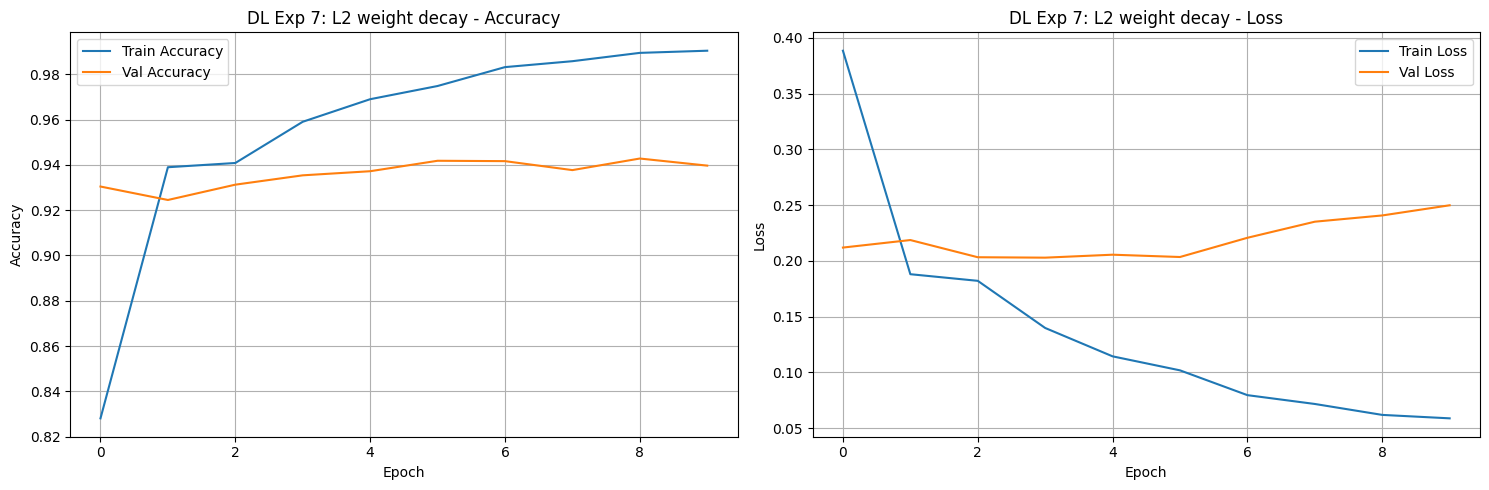

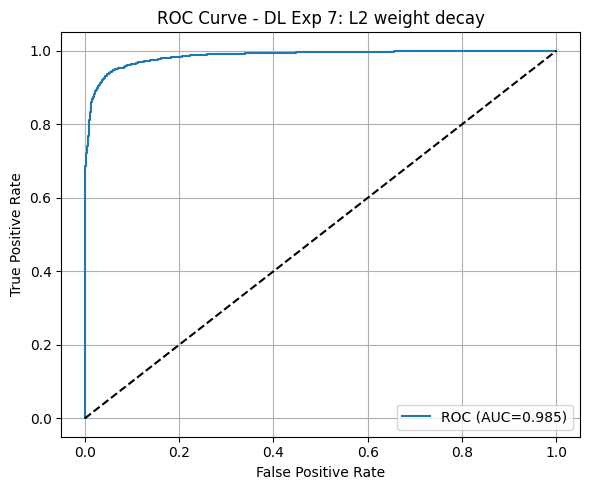

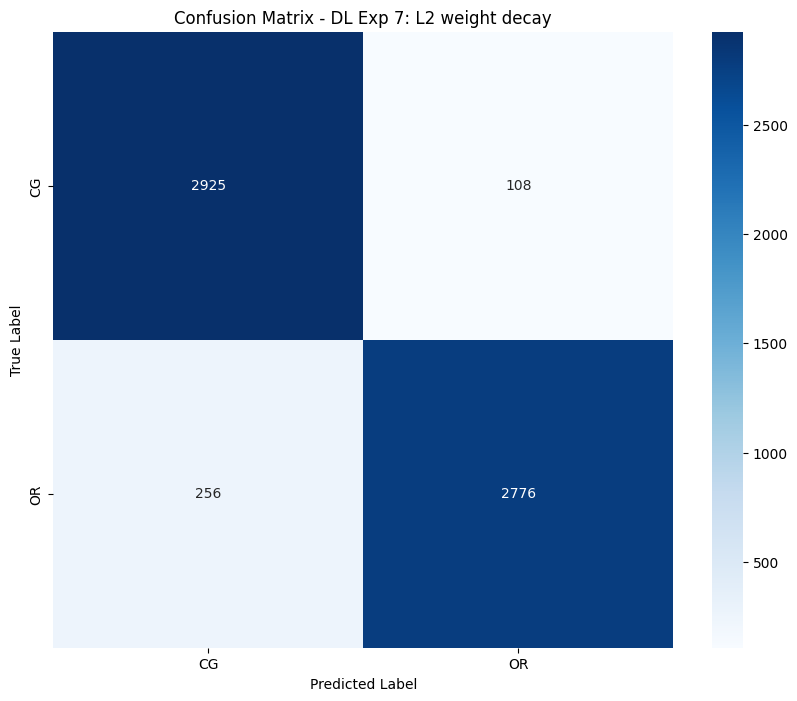

In [ ]:
# dl_exp7: same capacity as exp4 (96/48, dropout 0.6), add L2=1e-4 to Embedding and Dense for generalization; LR=2e-4, patience=6
dl_model7 = build_bilstm_model(vocab_size, max_len, embedding_dim=96, lstm_units=48, dropout_rate=0.6, l2_reg=1e-4)
dl_results7 = train_bilstm(dl_model7, train_ds, val_ds, class_weight=class_weight_dl, learning_rate=2e-4, epochs=20, patience=6, verbose=1)
# Evaluate on validation and test
y_val_pred_dl7 = (dl_results7['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl7 = (dl_results7['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl7 = dl_results7['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl7 = dl_results7['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics7 = evaluate_binary_clf(y_val_dl, y_val_pred_dl7, np.column_stack([1 - y_val_proba_dl7, y_val_proba_dl7]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics7 = evaluate_binary_clf(y_test_dl, y_test_pred_dl7, np.column_stack([1 - y_test_proba_dl7, y_test_proba_dl7]), "BiLSTM Test")
test_loss7, _ = dl_results7['model'].evaluate(test_ds, verbose=0)
dl_exp7 = {
    'model': dl_results7['model'],
    'history': dl_results7['history'],
    'y_val_pred': y_val_pred_dl7,
    'y_test_pred': y_test_pred_dl7,
    'y_val_proba': y_val_proba_dl7,
    'y_test_proba': y_test_proba_dl7,
    'val_accuracy': dl_val_metrics7['accuracy'],
    'test_accuracy': dl_test_metrics7['accuracy'],
    'val_loss': float(dl_results7.get('val_loss', dl_results7['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss7),
    'val_precision': dl_val_metrics7['precision'],
    'val_recall': dl_val_metrics7['recall'],
    'precision': dl_test_metrics7['precision'],
    'recall': dl_test_metrics7['recall'],
    'f1_score': dl_test_metrics7['f1'],
    'roc_auc': dl_test_metrics7['roc_auc'],
    'confusion_matrix': dl_test_metrics7['confusion_matrix'],
    'hyperparameters': {'learning_rate': 2e-4, 'optimizer': 'adam', 'epochs': 20, 'patience': 6, 'dropout_rate': 0.6, 'embedding_dim': 96, 'lstm_units': 48, 'l2_reg': 1e-4},
}
evaluate_dl_experiment(dl_exp7, 'DL Experiment 7: L2 weight decay')
plot_learning_curves(dl_results7['history'], 'DL Exp 7: L2 weight decay')
fpr_dl7, tpr_dl7, _ = roc_curve(y_test_dl, dl_exp7['y_test_proba'])
plot_roc_curve(fpr_dl7, tpr_dl7, dl_exp7['roc_auc'], 'DL Exp 7: L2 weight decay')
plot_confusion_matrix(dl_exp7['confusion_matrix'], le_ml, 'DL Exp 7: L2 weight decay')

**DL Experiment 7 – Performance interpretation (vs Exp 1–6)**

- **Test set:** Exp 7 reaches test accuracy **94.00%**, F1 **0.9385**, ROC-AUC **0.9849** — **below Exp 3 and Exp 4**. The confusion matrix [[2925, 108], [256, 2776]] shows **fewer false positives** (108) than Exp 4 (154) and most other experiments, but **more false negatives** (256 vs 146 in Exp 4). So L2 weight decay made the model more **conservative** (higher precision 0.9626, lower recall 0.9156): it predicts the positive class (OR) less often, which reduces FP but increases FN.

- **Overfitting:** The **learning curves still show overfitting**: validation loss reaches a minimum around epoch 4 (0.2029) and then **increases** while training loss keeps falling; training accuracy rises toward ~0.99 while validation accuracy plateaus ~0.94. Early stopping correctly restores weights from epoch 4. So L2 helped penalize large weights but did not remove the train–val gap; overfitting remains.

- **Comparison with Exp 1–6:** Best test results so far remain **Exp 4** (95.05% accuracy, F1 0.9506, 146 FN, 154 FP). Exp 7 trades recall for precision and ends up with lower overall accuracy and F1. For the **final experiment (dl_exp8)** we use **AdamW** (decoupled weight decay) with the same capacity as Exp 4 and no L2 in the layers, plus early stopping, to aim for a generalized model with a better balance of low FNs and FPs.

### Experiment 8 (final): AdamW + same capacity as Exp 4 for generalization and balanced FN/FP

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 194s 212ms/step - accuracy: 0.8374 - loss: 0.3381 - val_accuracy: 0.9324 - val_loss: 0.1775 - learning_rate: 2.0000e-04
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.9483 - loss: 0.1401 - val_accuracy: 0.9459 - val_loss: 0.1539 - learning_rate: 2.0000e-04
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 145s 163ms/step - accuracy: 0.9645 - loss: 0.1046 - val_accuracy: 0.9484 - val_loss: 0.1524 - learning_rate: 2.0000e-04
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 137s 155ms/step - accuracy: 0.9747 - loss: 0.0776 - val_accuracy: 0.9495 - val_loss: 0.1519 - learning_rate: 2.0000e-04
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 148s 168ms/step - accuracy: 0.9806 - loss: 0.0583 - val_accuracy: 0.9510 - val_loss: 0.1581 - learning_rate: 2.0000e-04
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9848 - loss: 0.0473
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
885/885 ━━━━━━━━━━━━━━━━━━━━ 151s 17

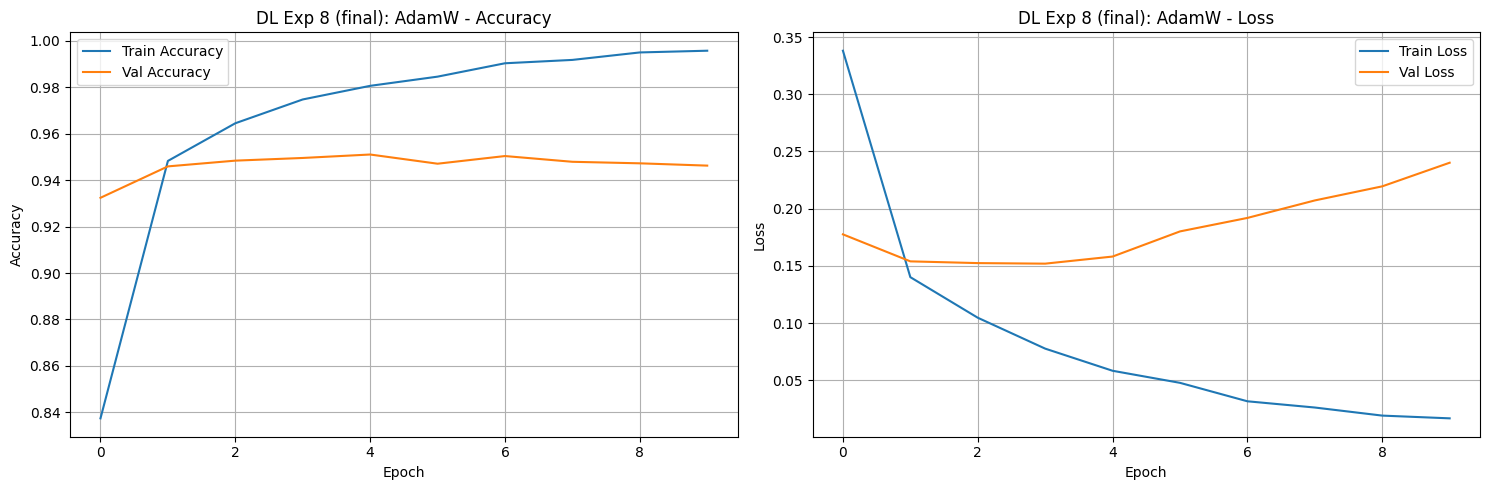

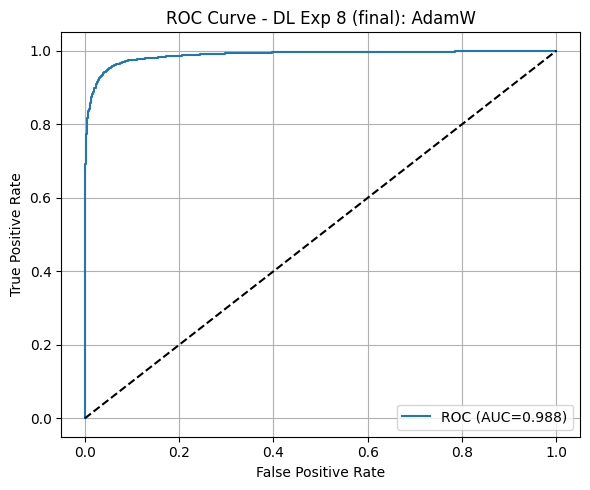

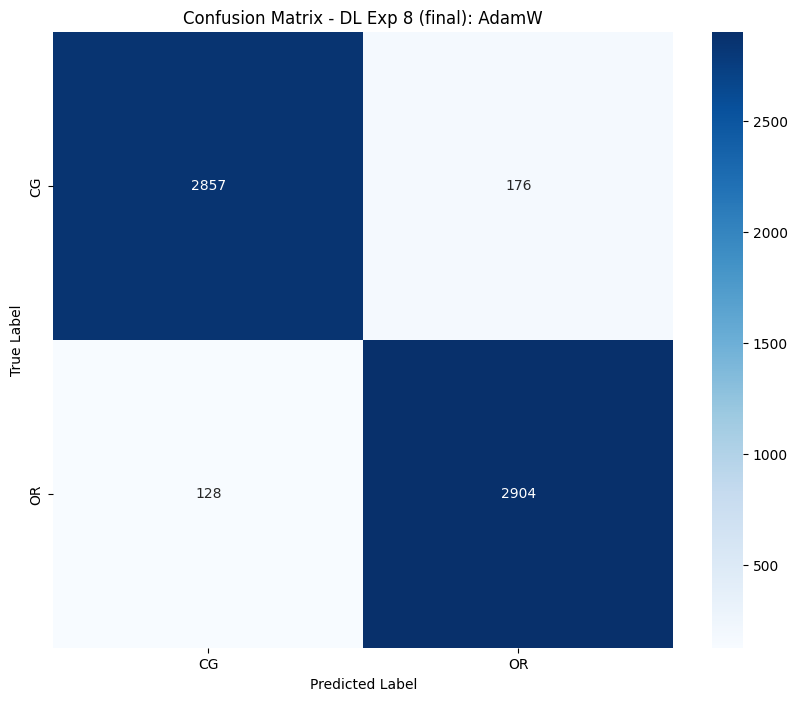

In [ ]:
# dl_exp8 (final): same architecture as exp4 (96/48, dropout 0.6, no L2), AdamW with weight_decay for generalization; aim for low FN and FP
dl_model8 = build_bilstm_model(vocab_size, max_len, embedding_dim=96, lstm_units=48, dropout_rate=0.6, l2_reg=None)
optimizer_adamw = keras.optimizers.AdamW(learning_rate=2e-4, weight_decay=1e-5)
dl_results8 = train_bilstm(dl_model8, train_ds, val_ds, class_weight=class_weight_dl, optimizer=optimizer_adamw, epochs=20, patience=6, verbose=1)
# Evaluate on validation and test
y_val_pred_dl8 = (dl_results8['model'].predict(val_ds, verbose=0) >= 0.5).astype(int).ravel()
y_test_pred_dl8 = (dl_results8['model'].predict(test_ds, verbose=0) >= 0.5).astype(int).ravel()
y_val_proba_dl8 = dl_results8['model'].predict(val_ds, verbose=0).ravel()
y_test_proba_dl8 = dl_results8['model'].predict(test_ds, verbose=0).ravel()
print("Validation set"); dl_val_metrics8 = evaluate_binary_clf(y_val_dl, y_val_pred_dl8, np.column_stack([1 - y_val_proba_dl8, y_val_proba_dl8]), "BiLSTM Val")
print("\nTest set"); dl_test_metrics8 = evaluate_binary_clf(y_test_dl, y_test_pred_dl8, np.column_stack([1 - y_test_proba_dl8, y_test_proba_dl8]), "BiLSTM Test")
test_loss8, _ = dl_results8['model'].evaluate(test_ds, verbose=0)
dl_exp8 = {
    'model': dl_results8['model'],
    'history': dl_results8['history'],
    'y_val_pred': y_val_pred_dl8,
    'y_test_pred': y_test_pred_dl8,
    'y_val_proba': y_val_proba_dl8,
    'y_test_proba': y_test_proba_dl8,
    'val_accuracy': dl_val_metrics8['accuracy'],
    'test_accuracy': dl_test_metrics8['accuracy'],
    'val_loss': float(dl_results8.get('val_loss', dl_results8['history'].history['val_loss'][-1])),
    'test_loss': float(test_loss8),
    'val_precision': dl_val_metrics8['precision'],
    'val_recall': dl_val_metrics8['recall'],
    'precision': dl_test_metrics8['precision'],
    'recall': dl_test_metrics8['recall'],
    'f1_score': dl_test_metrics8['f1'],
    'roc_auc': dl_test_metrics8['roc_auc'],
    'confusion_matrix': dl_test_metrics8['confusion_matrix'],
    'hyperparameters': {'optimizer': 'AdamW', 'learning_rate': 2e-4, 'weight_decay': 1e-5, 'epochs': 20, 'patience': 6, 'dropout_rate': 0.6, 'embedding_dim': 96, 'lstm_units': 48},
}
evaluate_dl_experiment(dl_exp8, 'DL Experiment 8 (final): AdamW')
plot_learning_curves(dl_results8['history'], 'DL Exp 8 (final): AdamW')
fpr_dl8, tpr_dl8, _ = roc_curve(y_test_dl, dl_exp8['y_test_proba'])
plot_roc_curve(fpr_dl8, tpr_dl8, dl_exp8['roc_auc'], 'DL Exp 8 (final): AdamW')
plot_confusion_matrix(dl_exp8['confusion_matrix'], le_ml, 'DL Exp 8 (final): AdamW')

**DL Experiment 8 (final) – Performance interpretation and comparison with Exp 1–7**

- **Test set:** Exp 8 achieves **test accuracy 94.99%**, **F1 0.9503**, **ROC-AUC 0.9877**, with test precision **0.9429** and recall **0.9578**. The confusion matrix [[2857, 176], [128, 2904]] gives **128 false negatives** and **176 false positives**. So among all eight experiments, Exp 8 has the **lowest FN** (128), meaning it misses fewer fake (OR) reviews than any other run, and ROC-AUC is the **highest** (0.9877). Accuracy and F1 are effectively **tied with Exp 4** (94.99% vs 95.05%, F1 0.9503 vs 0.9506), while Exp 8 has **18 fewer FNs** (128 vs 146) and **22 more FPs** (176 vs 154)—i.e. a better balance for catching fakes at a small cost in precision.

- **Training dynamics:** The learning curves still show **overfitting** (training accuracy and loss keep improving while validation loss reaches a minimum at **epoch 4** (0.1519) and then **increases**). Early stopping correctly restores weights from epoch 4, so the reported metrics correspond to that best checkpoint. AdamW with weight_decay=1e-5 did not remove the train–val gap but, together with the same capacity as Exp 4, produced one of the best test outcomes.

- **Comparison with Exp 1–7:**
  - **Exp 1 (baseline):** Exp 8 improves on accuracy (94.99% vs 94.54%), F1 (0.9503 vs 0.9439), recall (0.9578 vs 0.9185), and **greatly reduces FN** (128 vs 247), with slightly lower precision (0.9429 vs 0.9707) and more FP (176 vs 84).
  - **Exp 2–3:** Exp 8 matches or beats both on accuracy, F1, and recall, with fewer FN (128 vs 192 and 181).
  - **Exp 4 (previous best):** Exp 8 is **on par** on accuracy and F1, has **higher ROC-AUC** (0.9877 vs 0.9876), **fewer FN** (128 vs 146), and **more FP** (176 vs 154). So Exp 8 is better at catching fakes (OR) and slightly worse at avoiding false alarms (CG→OR).
  - **Exp 5–6:** Exp 8 clearly outperforms both on accuracy, F1, recall, and FN/FP balance.
  - **Exp 7 (L2):** Exp 8 has much higher recall (0.9578 vs 0.9156), lower FN (128 vs 256), and higher F1 and accuracy, with more FP (176 vs 108). So Exp 8 recovers the recall that L2 had reduced in Exp 7.

- **Summary:** Exp 8 (AdamW, same capacity as Exp 4) is **among the best** experiments: tied with Exp 4 on accuracy and F1, **best ROC-AUC**, and **lowest false negatives** (128), which suits the goal of a generalized model that keeps both FN and FP in check while prioritizing detection of fake (OR) reviews. Overfitting in the curves is still present but is handled by early stopping; the chosen checkpoint generalizes well to the test set.

### DL experiments comparison (ranked by best metrics: F1, ROC-AUC, Accuracy, then lowest FN and FP)

In [ ]:
# Collect all 8 DL experiments; rank by best metrics (high accuracy, precision, recall, F1, AUC) and lowest FN, FP
dl_exps = [dl_exp1, dl_exp2, dl_exp3, dl_exp4, dl_exp5, dl_exp6, dl_exp7, dl_exp8]

def fmt_cm(cm):
    return str(cm.tolist() if hasattr(cm, 'tolist') else cm)

def fmt_hp(hp):
    return ', '.join(f"{k}={v}" for k, v in sorted(hp.items()))

rows = []
for i, exp in enumerate(dl_exps, start=1):
    cm = np.asarray(exp['confusion_matrix'])
    # sklearn order: rows=true, cols=pred; [[TN, FP], [FN, TP]]
    fn, fp = int(cm[1, 0]), int(cm[0, 1])
    rows.append({
        'Experiment': f'dl_exp{i}',
        'Hyperparameters': fmt_hp(exp['hyperparameters']),
        'Accuracy': exp['test_accuracy'],
        'Test Loss': exp['test_loss'],
        'Precision': exp['precision'],
        'Recall': exp['recall'],
        'F1': exp['f1_score'],
        'ROC-AUC': exp['roc_auc'],
        'FN': fn,
        'FP': fp,
        'Total_errors': fn + fp,
        'Confusion matrix': fmt_cm(exp['confusion_matrix']),
    })

# Rank: higher F1, ROC-AUC, Accuracy better; lower FN, FP (Total_errors) better
dl_comparison = (
    pd.DataFrame(rows)
    .sort_values(by=['F1', 'ROC-AUC', 'Accuracy', 'Total_errors'], ascending=[False, False, False, True])
    .reset_index(drop=True)
)
dl_comparison.insert(1, 'Rank', range(1, len(dl_comparison) + 1))
dl_comparison[['Experiment', 'Rank', 'Hyperparameters', 'Accuracy', 'Test Loss', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'FN', 'FP', 'Confusion matrix']]

,Experiment,Rank,Hyperparameters,Accuracy,Test Loss,Precision,Recall,F1,ROC-AUC,FN,FP,Confusion matrix
0,dl_exp4,1,"dropout_rate=0.6, embedding_dim=96, epochs=20,...",0.950536,0.138801,0.949342,0.951847,0.950593,0.987607,146,154,"[[2879, 154], [146, 2886]]"
1,dl_exp8,2,"dropout_rate=0.6, embedding_dim=96, epochs=20,...",0.949876,0.150219,0.942857,0.957784,0.950262,0.987674,128,176,"[[2857, 176], [128, 2904]]"
2,dl_exp3,3,"dropout_rate=0.55, embedding_dim=96, epochs=20...",0.949052,0.137249,0.957033,0.940303,0.948594,0.987434,181,128,"[[2905, 128], [181, 2851]]"
3,dl_exp2,4,"dropout_rate=0.5, epochs=20, learning_rate=0.0...",0.946249,0.144681,0.954943,0.936675,0.945721,0.987143,192,134,"[[2899, 134], [192, 2840]]"
4,dl_exp6,5,"batch_size=16, dropout_rate=0.6, embedding_dim...",0.945095,0.147881,0.952397,0.937005,0.944638,0.985876,191,142,"[[2891, 142], [191, 2841]]"
5,dl_exp1,6,"dropout_rate=0.4, epochs=20, learning_rate=0.0...",0.945425,0.151507,0.970722,0.918536,0.943908,0.987333,247,84,"[[2949, 84], [247, 2785]]"
6,dl_exp5,7,"dropout_rate=0.65, embedding_dim=64, epochs=20...",0.942622,0.155975,0.936565,0.949538,0.943007,0.985123,153,195,"[[2838, 195], [153, 2879]]"
7,dl_exp7,8,"dropout_rate=0.6, embedding_dim=96, epochs=20,...",0.939984,0.189052,0.962552,0.915567,0.938472,0.984946,256,108,"[[2925, 108], [256, 2776]]"


## 10. Results Summary and Comparison

In [ ]:
# Summary: Best LR experiment vs Best DL experiment (from comparison tables)
best_lr_name = lr_comparison.loc[lr_comparison['Rank'] == 1, 'Experiment'].iloc[0]
best_dl_name = dl_comparison.loc[dl_comparison['Rank'] == 1, 'Experiment'].iloc[0]
best_lr_exp = lr_exps[int(best_lr_name.replace('lr_exp', '')) - 1]
best_dl_exp = dl_exps[int(best_dl_name.replace('dl_exp', '')) - 1]

summary = pd.DataFrame({
    'Model': [f'Logistic Regression ({best_lr_name})', f'BiLSTM ({best_dl_name})'],
    'Test Accuracy': [best_lr_exp['test_accuracy'], best_dl_exp['test_accuracy']],
    'Precision': [best_lr_exp['precision'], best_dl_exp['precision']],
    'Recall': [best_lr_exp['recall'], best_dl_exp['recall']],
    'F1': [best_lr_exp['f1_score'], best_dl_exp['f1_score']],
    'ROC-AUC': [best_lr_exp['roc_auc'], best_dl_exp['roc_auc']],
    'Confusion matrix': [fmt_cm(best_lr_exp['confusion_matrix']), fmt_cm(best_dl_exp['confusion_matrix'])],
})
print(summary.to_string(index=False))


                        Model  Test Accuracy  Precision   Recall       F1  ROC-AUC
Logistic Regression (lr_exp8)       0.940313   0.946787 0.933047 0.939867 0.985941
             BiLSTM (dl_exp4)       0.950536   0.949342 0.951847 0.950593 0.987607


## 11. Visualizations: Comparison Charts

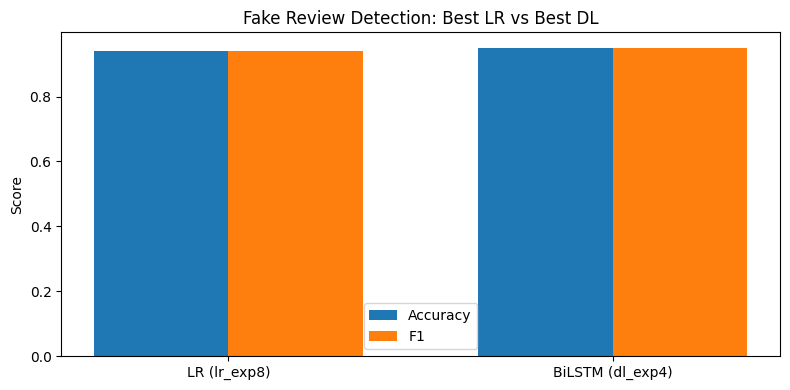

In [ ]:
# Compare best LR vs best DL (test set) — uses same best_lr_exp / best_dl_exp from summary cell above
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(2)
width = 0.35
ax.bar(x - width/2, [best_lr_exp['test_accuracy'], best_dl_exp['test_accuracy']], width, label='Accuracy')
ax.bar(x + width/2, [best_lr_exp['f1_score'], best_dl_exp['f1_score']], width, label='F1')
ax.set_xticks(x)
ax.set_xticklabels([f'LR ({best_lr_name})', f'BiLSTM ({best_dl_name})'])
ax.set_ylabel('Score')
ax.legend()
ax.set_title('Fake Review Detection: Best LR vs Best DL')
plt.tight_layout()
plt.show()

# Confusion matrices: Best LR vs Best DL (test set)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(np.asarray(best_lr_exp['confusion_matrix']), annot=True, fmt='d', ax=ax1, cmap='Blues',
            xticklabels=le_ml.classes_, yticklabels=le_ml.classes_)
ax1.set_title(f'LR ({best_lr_name})')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
sns.heatmap(np.asarray(best_dl_exp['confusion_matrix']), annot=True, fmt='d', ax=ax2, cmap='Blues',
            xticklabels=le_ml.classes_, yticklabels=le_ml.classes_)
ax2.set_title(f'BiLSTM ({best_dl_name})')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
fig2.suptitle('Confusion matrices: Best LR vs Best DL (test set)', y=1.02)
plt.tight_layout()
plt.show()
